# Preprocessing Workflow Structure

So let's get our hands dirty. First things first, it's always good to know which interfaces you want to use in your workflow and in which order you want to execute them. For the preprocessing workflow, I recommend that we use the following nodes:

     1. Gunzip (Nipype)
     2. Drop Dummy Scans (FSL)
     3. Slice Time Correction (SPM)
     4. Motion Correction (SPM)
     5. Artifact Detection
     6. Segmentation (SPM)
     7. Coregistration (FSL)
     8. Smoothing (FSL)
     9. Apply Binary Mask (FSL)
    10. Remove Linear Trends (Nipype)

## Imports

In [1]:
from nipype import Node, Workflow, Merge, IdentityInterface, SelectFiles, MapNode
from nipype.interfaces.io import DataSink
import nibabel as nb
import matplotlib.pyplot as plt
from nipype.interfaces.fsl import ExtractROI, MCFLIRT, FLIRT, Threshold, ApplyMask
from nipype.interfaces.spm import SliceTiming, NewSegment
from nilearn import image as nli
from nilearn.plotting import plot_stat_map, plot_anat, plot_epi
from nipype.algorithms.rapidart import ArtifactDetect
from nipype.algorithms.confounds import TSNR
from nipype.workflows.fmri.fsl.preprocess import create_susan_smooth
from IPython.display import Image, SVG
import numpy as np

211113-09:14:31,973 nipype.utils WARNING:
	 A newer version (1.7.0) of nipy/nipype is available. You are using 1.6.1


/opt/miniconda-latest/envs/neuro/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "
/opt/miniconda-latest/envs/neuro/lib/python3.8/site-packages/niflow/nipype1/workflows/dmri/mrtrix/group_connectivity.py:16: UserWarning: cmp not installed
  warnings.warn('cmp not installed')
/src/nipype/nipype/workflows/__init__.py:28: UserWarning: Nipype 1 workflows have been moved to the niflow-nipype1-workflows package. nipype.workflows.* provides a reference for backwards compatibility. Please use niflow.nipype1.workflows.* to avoid this warning.
  warnings.warn(" ".join(_msg))


## Create Nodes

Let's create all the nodes that we need! Make sure to specify all relevant inputs and keep in mind which ones you later on need to connect in your pipeline.

### Drop Dummy Scans

The functional images of this dataset were recorded with 4 dummy scans at the beginning (see the [corresponding publication](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3641991/)). But those dummy scans were not yet taken out from the functional images.

In [2]:
extract = Node(ExtractROI(t_min=4, t_size=-1, output_type='NIFTI'),
               name="extract")

### IdentityInterface 
Specify where the input data can be found & where and how to save the output data.

In [3]:
subject_list = ['07', '08']
task_list = ['1']
infosource = Node(IdentityInterface(fields=['subject_id', 'task_name']),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list),
                        ('task_name', task_list)]

## Datainput with `SelectFiles` and `iterables` 

For this, we need [`SelectFiles`](../../../nipype_tutorial/notebooks/basic_data_input.ipynb#SelectFiles) and [`iterables`](../../../nipype_tutorial/notebooks/basic_iteration.ipynb)! It's rather simple, specify a template and fill-up the placeholder variables.

In [23]:
subject_list = ['%02d'%i for i in range(1,23)]
task_list = ['1', '2', '3', '4']
# String template with {}-based strings
templates = {'anat': 'sub-{subject_id}/ses-test/anat/sub-{subject_id}_ses-test_anat_sT1W.nii',
             'func': 'sub-{subject_id}/ses-test/func/sub-{subject_id}_ses-test_session{task_number}_bold.nii'}
# Create SelectFiles node
selectfiles = Node(SelectFiles(templates,
                      base_directory='/home/neuro/Data/Visual_search_task/BIDS_data',
                      sort_filelist=True),
          name='selectfiles')
selectfiles.iterables = [('subject_id', subject_list), ('task_number', task_list)]

### Slice Time Correction

Now to the next step. Let's us SPM's `SliceTiming` to correct for slice wise acquisition of the volumes. As a reminder, the tutorial dataset was recorded...
- with a time repetition (TR) of 2.5 seconds
- with 30 slices per volume
- in an interleaved fashion, i.e. slice order is [1, 3, 5, 7, ..., 2, 4, 6, ..., 30]
- with a time acquisition (TA) of 2.4167 seconds, i.e. `TR-(TR/num_slices)`

In [5]:
slice_order = list(range(1, 32, 2)) + list(range(2, 32, 2))
slicetime = Node(SliceTiming(num_slices=31,
                             ref_slice=2,
                             slice_order=slice_order,
                             time_repetition=2,
                             time_acquisition=2-(2/31)),
                 name='slicetime')

stty: 'standard input': Inappropriate ioctl for device


### Motion Correction

To correct for motion in the scanner, we will be using FSL's `MCFLIRT`.

In [6]:
mcflirt = Node(MCFLIRT(mean_vol=True,
                       save_plots=True),
               name="mcflirt")

### Artifact Detection

We will use the really cool and useful `ArtifactDetection` tool from Nipype to detect motion and intensity outliers in the functional images. The interface is initiated as follows:

In [7]:
art = Node(ArtifactDetect(norm_threshold=2,
                          zintensity_threshold=3,
                          mask_type='spm_global',
                          parameter_source='FSL',
                          use_differences=[True, False],
                          plot_type='svg'),
           name="art")

The parameters above mean the following:
- `norm_threshold` - Threshold to use to detect motion-related outliers when composite motion is being used
- `zintensity_threshold` - Intensity Z-threshold use to detection images that deviate from the mean
- `mask_type` - Type of mask that should be used to mask the functional data. *spm_global* uses an spm_global like calculation to determine the brain mask
- `parameter_source` - Source of movement parameters
- `use_differences` - If you want to use differences between successive motion (first element) and intensity parameter (second element) estimates in order to determine outliers

### Segmentation of anatomical image

Now let's work on the anatomical image. In particular, let's use SPM's `NewSegment` to create probability maps for the gray matter, white matter tissue and CSF.

In [8]:
# Use the following tissue specification to get a GM and WM probability map
tpm_img ='/opt/spm12-r7219/spm12_mcr/spm12/tpm/TPM.nii'
tissue1 = ((tpm_img, 1), 1, (True,False), (False, False))
tissue2 = ((tpm_img, 2), 1, (True,False), (False, False))
tissue3 = ((tpm_img, 3), 2, (True,False), (False, False))
tissue4 = ((tpm_img, 4), 3, (False,False), (False, False))
tissue5 = ((tpm_img, 5), 4, (False,False), (False, False))
tissue6 = ((tpm_img, 6), 2, (False,False), (False, False))
tissues = [tissue1, tissue2, tissue3, tissue4, tissue5, tissue6]
segment = Node(NewSegment(tissues=tissues), name='segment')

### Compute Coregistration Matrix

As a next step, we will make sure that the functional images are coregistered to the anatomical image. For this, we will use FSL's `FLIRT` function. As we just created a white matter probability map, we can use this together with the Boundary-Based Registration (BBR) cost function to optimize the image coregistration. As some helpful notes...
- use a degree of freedom of 6
- specify the cost function as `bbr`
- use the `schedule='/usr/share/fsl/5.0/etc/flirtsch/bbr.sch'`

In [9]:
coreg = Node(FLIRT(dof=6,
                   cost='bbr',
                   schedule='/usr/share/fsl/5.0/etc/flirtsch/bbr.sch',
                   output_type='NIFTI'),
             name="coreg")

As mentioned above, the `bbr` routine can use the subject-specific white matter probability map to guide the coregistration. But for this, we need to create a binary mask out of the WM probability map. This can easily be done by FSL's `Threshold` interface.

In [10]:
# Threshold - Threshold WM probability image
threshold_WM = Node(Threshold(thresh=0.5,
                              args='-bin',
                              output_type='NIFTI'),
                name="threshold_WM")

# Select WM segmentation file from segmentation output
def get_wm(files):
    return files[1][0]

Now, to select the WM probability map that the `NewSegment` node created, we need some helper function. Because the output field `partial_volume_files` form the segmentation node, will give us a list of files, i.e. `[[GM_prob], [WM_prob], [], [], [], []]`. Therefore, using the following function, we can select only the last element of this list.

### Apply Coregistration Matrix to functional image

Now that we know the coregistration matrix to correctly overlay the functional mean image on the subject-specific anatomy, we need to apply to coregistration to the whole time series. This can be achieved with FSL's `FLIRT` as follows:

In [11]:
# Specify the isometric voxel resolution you want after coregistration
desired_voxel_iso = 4
# Apply coregistration warp to functional images
applywarp = Node(FLIRT(interp='spline',
                       apply_isoxfm=desired_voxel_iso,
                       output_type='NIFTI'),
                 name="applywarp")

**<span style="color:red">Important</span>**: As you can see above, we also specified a variable `desired_voxel_iso`. This is very important at this stage, otherwise `FLIRT` will transform your functional images to a resolution of the anatomical image, which will dramatically increase the file size (e.g. to 1-10GB per file). If you don't want to change the voxel resolution, use the additional parameter `no_resample=True`. Important, for this to work, you still need to define `apply_isoxfm`.

### Smoothing

Next step is image smoothing. The most simple way to do this is to use FSL's or SPM's `Smooth` function. But for learning purposes, let's use FSL's `SUSAN` workflow as it is implemented in Nipype. Note that this time, we are importing a workflow instead of an interface.

If you type `create_susan_smooth?` you can see how to specify the input variables to the susan workflow. In particular, they are...
- `fwhm`: set this value to 4 (or whichever value you want)
- `mask_file`: will be created in a later step
- `in_file`: will be handled while connection to other nodes in the preproc workflow

In [12]:
susan = create_susan_smooth(name='susan')
susan.inputs.inputnode.fwhm = 8

### Create Binary Mask

There are many possible approaches on how you can mask your functional images. One of them is not at all, one is with a simple brain mask and one that only considers certain kind of brain tissue, e.g. gray matter.

For the current example, we want to create a dilated gray matter mask. For this purpose we need to:
1. Resample the gray matter probability map to the same resolution as the functional images
2. Threshold this resampled probability map at a specific value
3. Dilate this mask by some voxels to make the mask less conservative and more inclusive

The first step can be done in many ways (eg. using freesurfer's `mri_convert`, `nibabel`) but in our case, we will use FSL's `FLIRT`. The trick is to use the probability mask, as input file and a reference file.

In [13]:
# Initiate resample node
resample = Node(FLIRT(apply_isoxfm=desired_voxel_iso,
                      output_type='NIFTI'),
                name="resample")

The second and third step can luckily be done with just one node. We can take almost the same `Threshold` node as above. We just need to add another additional argument: `-dilF` - which applies a maximum filtering of all voxels.

In [14]:
# Threshold - Threshold GM probability image
mask_GM = Node(Threshold(thresh=0.5,
                         args='-bin -dilF',
                         output_type='NIFTI'),
                name="mask_GM")

# Select GM segmentation file from segmentation output
def get_gm(files):
    return files[0][0]

To apply the mask to the smoothed functional images, we will use FSL's `ApplyMask` interface.

**Important:** The susan workflow gives out a list of files, i.e. `[smoothed_func.nii]` instead of just the filename directly. If we would use a normal `Node` for `ApplyMask` this would lead to the following error:

    TraitError: The 'in_file' trait of an ApplyMaskInput instance must be an existing file name, but a value of ['/output/work_preproc/susan/smooth/mapflow/_smooth0/asub-07_ses-test_task-fingerfootlips_bold_mcf_flirt_smooth.nii.gz'] <class 'list'> was specified.


To prevent this we will be using a `MapNode` and specify the `in_file` as it's iterfield. Like this, the node is capable to handle a list of inputs as it will know that it has to apply itself iteratively to the list of inputs.

In [15]:
mask_func = MapNode(ApplyMask(output_type='NIFTI'),
                    name="mask_func", 
                    iterfield=["in_file"])

### Remove linear trends in functional images

Last but not least. Let's use Nipype's `TSNR` module to remove linear and quadratic trends in the functionally smoothed images. For this, you only have to specify the `regress_poly` parameter in the node initiation.

In [16]:
detrend = Node(TSNR(regress_poly=2), name="detrend")

## Data output with `DataSink`

The results look fine, but we don't need all those temporary files. So let's use Datasink to keep only those files that we actually need for the 1st and 2nd level analysis.

In [17]:
output_folder = 'preproc_result'
datasink = Node(DataSink(base_directory='/home/neuro/Result/Visual_search_task/preproc_working_dir/',
                         container=output_folder), name="datasink")

In [18]:
## Use the following substitutions for the DataSink output
substitutions = [('asub', 'sub'),
                 ('_ses-test_task-fingerfootlips_bold_roi_mcf', ''),
                 ('.nii.gz.par', '.par'),
                 ]

# To get rid of the folder '_subject_id_07' and renaming detrend
substitutions += [('_subject_id_%s/detrend' % s,
                   '_subject_id_%s/sub-%s_detrend' % (s, s)) for s in subject_list]
substitutions += [('_subject_id_%s/' % s, '') for s in subject_list]
datasink.inputs.substitutions = substitutions

### Workflow

And for this, we first need to create a workflow:

In [24]:
preproc = Workflow(base_dir='/home/neuro/Result/Visual_search_task/preproc_working_dir', name='preproc')

In [25]:
preproc.connect([(selectfiles, slicetime, [('func', 'in_files')]),
                  (slicetime, mcflirt, [('timecorrected_files', 'in_file')]),
                  (mcflirt, art, [('out_file', 'realigned_files'), ('par_file', 'realignment_parameters')]), 
                  (selectfiles, segment, [('anat', 'channel_files')]), 
                  (selectfiles, coreg, [('anat', 'reference')]), 
                  (mcflirt, coreg, [('mean_img', 'in_file')]), 
                  (segment, threshold_WM, [(('native_class_images', get_wm), 'in_file')]), 
                  (threshold_WM, coreg, [('out_file', 'wm_seg')]), 
                  (mcflirt, applywarp, [('out_file', 'in_file')]),
                  (coreg, applywarp, [('out_matrix_file', 'in_matrix_file')]),
                  (selectfiles, applywarp, [('anat', 'reference')]), 
                  (applywarp, susan, [('out_file', 'inputnode.in_files')]), 
                  (segment, resample, [(('native_class_images', get_gm), 'in_file'), 
                                        (('native_class_images', get_gm), 'reference')]), 
                  (resample, mask_GM, [('out_file', 'in_file')]), 
                  (mask_GM, susan, [('out_file', 'inputnode.mask_file')]), 
                  (susan, mask_func, [('outputnode.smoothed_files', 'in_file')]),
                  (mask_GM, mask_func, [('out_file', 'mask_file')]), 
                  (mask_func, detrend, [('out_file', 'in_file')])])
preproc.connect([(art, datasink, [('outlier_files', 'outlier_files'),
                                  ('plot_files', 'plot_files')]),
                 (mcflirt, datasink, [('par_file', 'par')]),
                 (detrend, datasink, [('detrended_file', 'func')]),
                 ])

## Visualize the workflow

Now that we're done. Let's look at the workflow that we just created.

211113-07:59:42,137 nipype.workflow INFO:
	 Generated workflow graph: /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/graph.png (graph2use=flat, simple_form=True).


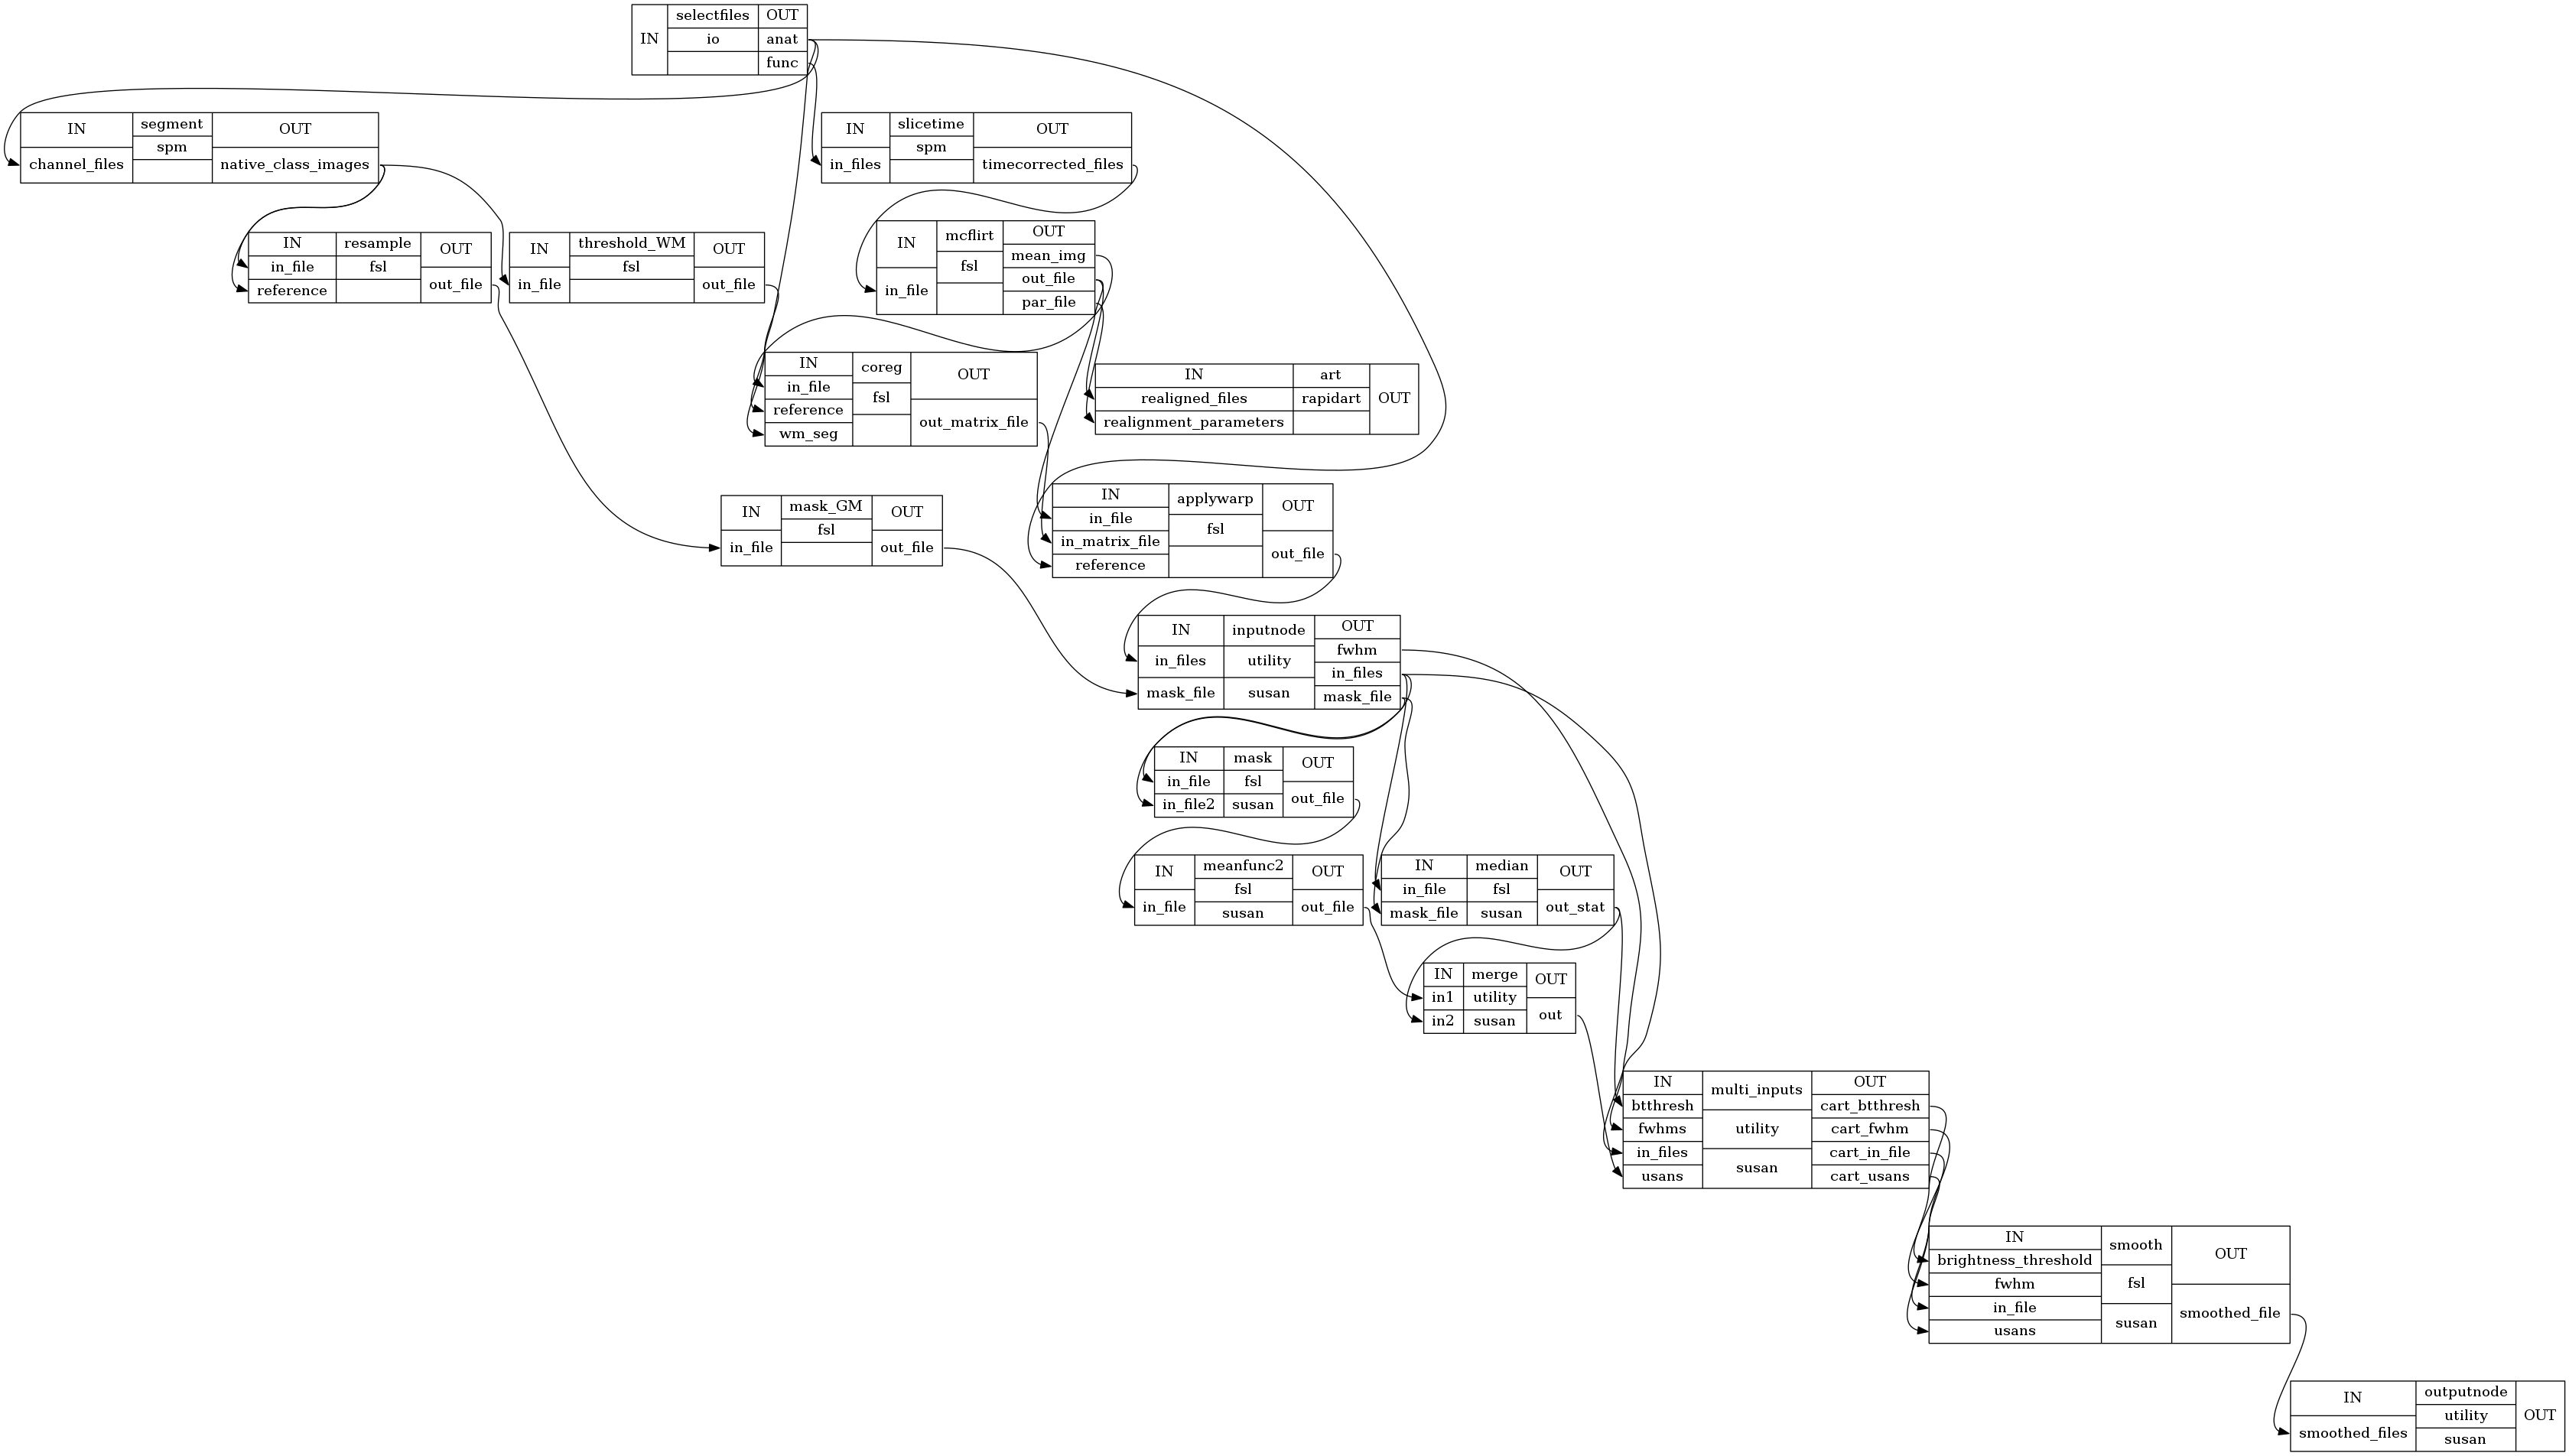

In [73]:
preproc.write_graph(graph2use='flat')
Image('/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/graph_detailed.png')

211113-09:15:21,73 nipype.workflow INFO:
	 Generated workflow graph: /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/graph.png (graph2use=colored, simple_form=True).


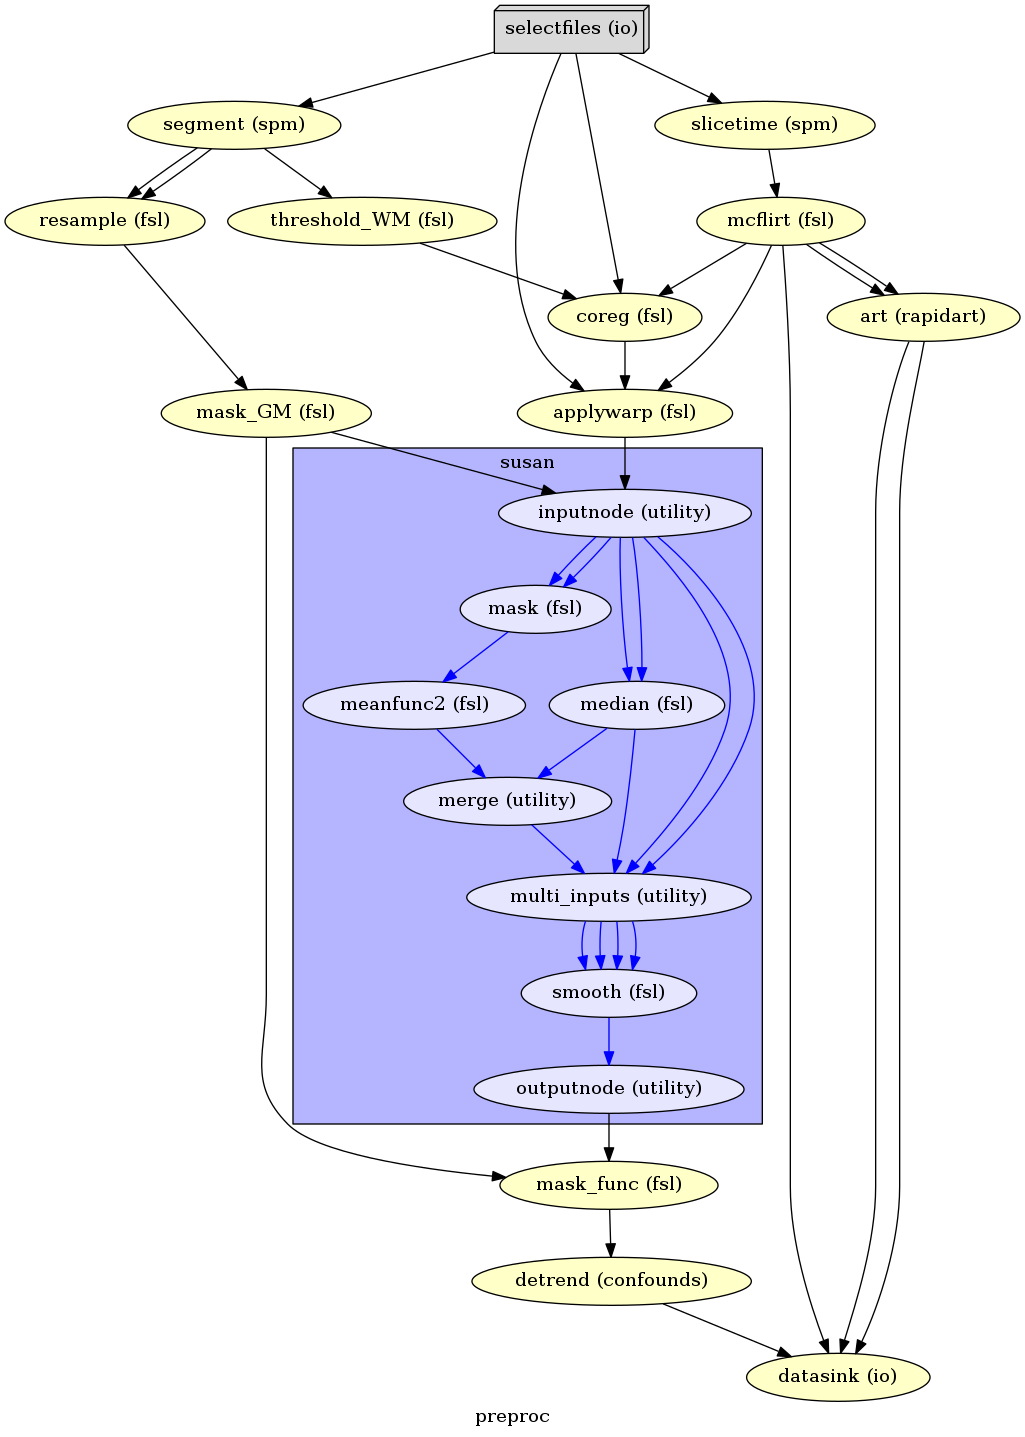

In [21]:
preproc.write_graph(graph2use='colored', format='png', simple_form=True)
Image(filename='/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/graph.png', width=750)

##  Run the Workflow

Now we are ready to run the workflow! Be careful about the `n_procs` parameter if you run a workflow in `'MultiProc'` mode. `n_procs` specifies the number of jobs/cores your computer will use to run the workflow. If this number is too high your computer will try to execute too many things at once and will most likely crash.

**Note**: If  you're using a Docker container and FLIRT fails to run without any good reason, you might need to change memory settings in the Docker preferences (6 GB should be enough for this workflow).

In [26]:
preproc.run('MultiProc', plugin_args={'n_procs': 5})

211113-09:17:38,24 nipype.workflow INFO:
	 Workflow preproc settings: ['check', 'execution', 'logging', 'monitoring']
211113-09:17:40,662 nipype.workflow INFO:
	 Running in parallel.
211113-09:17:40,679 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 88 jobs ready. Free memory (GB): 12.30/12.30, Free processors: 5/5.
211113-09:17:40,794 nipype.workflow INFO:
	 [Node] Setting-up "preproc.selectfiles" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_22_task_number_4/selectfiles".
211113-09:17:40,800 nipype.workflow INFO:
	 [Node] Setting-up "preproc.selectfiles" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_22_task_number_3/selectfiles".
211113-09:17:40,807 nipype.workflow INFO:
	 [Node] Setting-up "preproc.selectfiles" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_22_task_number_2/selectfiles".
211113-09:17:40,813 nipype.workflow INFO:
	 [Node] Setting-up "preproc.selectfile

stty: 'standard input': Inappropriate ioctl for device


211113-09:23:37,19 nipype.workflow INFO:
	 [Job 495] Completed (preproc.segment).
211113-09:23:37,23 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 62 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.slicetime
                       * preproc.segment
                       * preproc.mcflirt
                       * preproc.mcflirt
211113-09:23:37,106 nipype.workflow INFO:
	 [Node] Setting-up "preproc.resample" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_16_task_number_2/resample".
211113-09:23:37,141 nipype.workflow INFO:
	 [Node] Running "resample" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_16_task_number_2/segment/c1sub-16_ses-test_anat_sT1W.nii -ref /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_

stty: 'standard input': Inappropriate ioctl for device


211113-09:24:07,43 nipype.workflow INFO:
	 [Job 514] Completed (preproc.segment).
211113-09:24:07,47 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 62 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.segment
                       * preproc.slicetime
                       * preproc.mcflirt
                       * preproc.mcflirt
211113-09:24:07,130 nipype.workflow INFO:
	 [Node] Setting-up "preproc.resample" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_16_task_number_1/resample".
211113-09:24:07,170 nipype.workflow INFO:
	 [Node] Running "resample" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_16_task_number_1/segment/c1sub-16_ses-test_anat_sT1W.nii -ref /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_

stty: 'standard input': Inappropriate ioctl for device


211113-09:26:01,134 nipype.workflow INFO:
	 [Job 518] Completed (preproc.slicetime).
211113-09:26:01,138 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 61 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.coreg
                       * preproc.coreg
                       * preproc.slicetime
                       * preproc.segment
211113-09:26:01,229 nipype.workflow INFO:
	 [Node] Setting-up "preproc.art" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_16_task_number_2/art".
211113-09:26:01,279 nipype.workflow INFO:
	 [Node] Running "art" ("nipype.algorithms.rapidart.ArtifactDetect")
211113-09:26:03,140 nipype.workflow INFO:
	 [MultiProc] Running 5 tasks, and 60 jobs ready. Free memory (GB): 11.30/12.30, Free processors: 0/5.
                     Currently running:
                       * preproc.art
                       * preproc.coreg
               

stty: 'standard input': Inappropriate ioctl for device


211113-09:26:43,169 nipype.workflow INFO:
	 [Job 537] Completed (preproc.slicetime).
211113-09:26:43,172 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 60 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.applywarp
                       * preproc.applywarp
                       * preproc.mcflirt
                       * preproc.segment
211113-09:26:43,253 nipype.workflow INFO:
	 [Node] Setting-up "preproc.mcflirt" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_15_task_number_4/mcflirt".
211113-09:26:43,287 nipype.workflow INFO:
	 [Node] Running "mcflirt" ("nipype.interfaces.fsl.preprocess.MCFLIRT"), a CommandLine Interface with command:
mcflirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_15_task_number_4/slicetime/asub-15_ses-test_session4_bold.nii -meanvol -out /home/neuro/Result/Visual_search_task/preproc_working_

stty: 'standard input': Inappropriate ioctl for device


211113-09:26:59,179 nipype.workflow INFO:
	 [Job 533] Completed (preproc.segment).
211113-09:26:59,187 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 61 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.mcflirt
                       * preproc.applywarp
                       * preproc.applywarp
                       * preproc.mcflirt
211113-09:26:59,264 nipype.workflow INFO:
	 [Node] Setting-up "preproc.resample" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_15_task_number_4/resample".
211113-09:26:59,303 nipype.workflow INFO:
	 [Node] Running "resample" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_15_task_number_4/segment/c1sub-15_ses-test_anat_sT1W.nii -ref /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subj

stty: 'standard input': Inappropriate ioctl for device


211113-09:30:21,348 nipype.workflow INFO:
	 [Job 552] Completed (preproc.segment).
211113-09:30:21,353 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 61 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.coreg
                       * preproc.coreg
                       * preproc.segment
                       * preproc.slicetime
211113-09:30:21,436 nipype.workflow INFO:
	 [Node] Setting-up "preproc.art" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_15_task_number_4/art".
211113-09:30:21,476 nipype.workflow INFO:
	 [Node] Running "art" ("nipype.algorithms.rapidart.ArtifactDetect")
211113-09:30:23,352 nipype.workflow INFO:
	 [MultiProc] Running 5 tasks, and 60 jobs ready. Free memory (GB): 11.30/12.30, Free processors: 0/5.
                     Currently running:
                       * preproc.art
                       * preproc.coreg
                 

stty: 'standard input': Inappropriate ioctl for device


211113-09:30:59,378 nipype.workflow INFO:
	 [Job 556] Completed (preproc.slicetime).
211113-09:30:59,382 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 58 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.slicetime
                       * preproc.coreg
                       * preproc.coreg
                       * preproc.segment
211113-09:30:59,460 nipype.workflow INFO:
	 [Node] Setting-up "preproc.mcflirt" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_15_task_number_3/mcflirt".
211113-09:30:59,495 nipype.workflow INFO:
	 [Node] Running "mcflirt" ("nipype.interfaces.fsl.preprocess.MCFLIRT"), a CommandLine Interface with command:
mcflirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_15_task_number_3/slicetime/asub-15_ses-test_session3_bold.nii -meanvol -out /home/neuro/Result/Visual_search_task/preproc_working_dir/pr

stty: 'standard input': Inappropriate ioctl for device


211113-09:31:53,425 nipype.workflow INFO:
	 [Job 571] Completed (preproc.segment).
211113-09:31:53,429 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 59 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.applywarp
                       * preproc.mcflirt
                       * preproc.slicetime
                       * preproc.coreg
211113-09:31:53,514 nipype.workflow INFO:
	 [Node] Setting-up "preproc.resample" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_15_task_number_2/resample".
211113-09:31:53,550 nipype.workflow INFO:
	 [Node] Running "resample" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_15_task_number_2/segment/c1sub-15_ses-test_anat_sT1W.nii -ref /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subjec

stty: 'standard input': Inappropriate ioctl for device


211113-09:32:55,474 nipype.workflow INFO:
	 [Job 575] Completed (preproc.slicetime).
211113-09:32:55,476 nipype.workflow INFO:
	 [Job 540] Completed (preproc.applywarp).
211113-09:32:55,483 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 60 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 2/5.
                     Currently running:
                       * preproc.susan.smooth
                       * preproc.segment
                       * preproc.mcflirt
211113-09:32:55,598 nipype.workflow INFO:
	 [Node] Setting-up "preproc.susan.mask" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/susan/_subject_id_15_task_number_4/mask".
211113-09:32:55,605 nipype.workflow INFO:
	 [Node] Setting-up "preproc.susan.median" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/susan/_subject_id_15_task_number_4/median".
211113-09:32:55,642 nipype.workflow INFO:
	 [Node] Setting-up "_mask0" in "/home/neuro/Result/Visual_search_task/preproc_wo

stty: 'standard input': Inappropriate ioctl for device


211113-09:35:21,576 nipype.workflow INFO:
	 [Job 590] Completed (preproc.segment).
211113-09:35:21,580 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 59 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.coreg
                       * preproc.segment
                       * preproc.slicetime
                       * preproc.mcflirt
211113-09:35:21,679 nipype.workflow INFO:
	 [Node] Setting-up "preproc.art" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_15_task_number_3/art".
211113-09:35:21,726 nipype.workflow INFO:
	 [Node] Running "art" ("nipype.algorithms.rapidart.ArtifactDetect")
211113-09:35:23,580 nipype.workflow INFO:
	 [MultiProc] Running 5 tasks, and 58 jobs ready. Free memory (GB): 11.30/12.30, Free processors: 0/5.
                     Currently running:
                       * preproc.art
                       * preproc.coreg
               

stty: 'standard input': Inappropriate ioctl for device


211113-09:35:37,289 nipype.workflow INFO:
	 [Node] Finished "preproc.resample".
211113-09:35:37,588 nipype.workflow INFO:
	 [Job 594] Completed (preproc.slicetime).
211113-09:35:37,590 nipype.workflow INFO:
	 [Job 591] Completed (preproc.resample).
211113-09:35:37,594 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 59 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 2/5.
                     Currently running:
                       * preproc.coreg
                       * preproc.segment
                       * preproc.mcflirt
211113-09:35:37,671 nipype.workflow INFO:
	 [Node] Setting-up "preproc.mask_GM" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_15_task_number_1/mask_GM".
211113-09:35:37,672 nipype.workflow INFO:
	 [Node] Setting-up "preproc.threshold_WM" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_15_task_number_1/threshold_WM".
211113-09:35:37,705 nipype.workflow INFO:
	 [Node] Runnin

stty: 'standard input': Inappropriate ioctl for device


211113-09:36:59,648 nipype.workflow INFO:
	 [Job 609] Completed (preproc.segment).
211113-09:36:59,652 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 58 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.coreg
                       * preproc.applywarp
                       * preproc.slicetime
                       * preproc.mcflirt
211113-09:36:59,730 nipype.workflow INFO:
	 [Node] Setting-up "preproc.art" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_15_task_number_2/art".
211113-09:36:59,764 nipype.workflow INFO:
	 [Node] Running "art" ("nipype.algorithms.rapidart.ArtifactDetect")
211113-09:37:01,652 nipype.workflow INFO:
	 [MultiProc] Running 5 tasks, and 57 jobs ready. Free memory (GB): 11.30/12.30, Free processors: 0/5.
                     Currently running:
                       * preproc.art
                       * preproc.coreg
             

stty: 'standard input': Inappropriate ioctl for device


211113-09:37:55,687 nipype.workflow INFO:
	 [Job 613] Completed (preproc.slicetime).
211113-09:37:55,692 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 56 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.segment
                       * preproc.susan.smooth
                       * preproc.coreg
                       * preproc.mcflirt
211113-09:37:55,770 nipype.workflow INFO:
	 [Node] Setting-up "preproc.mcflirt" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_14_task_number_4/mcflirt".
211113-09:37:55,809 nipype.workflow INFO:
	 [Node] Running "mcflirt" ("nipype.interfaces.fsl.preprocess.MCFLIRT"), a CommandLine Interface with command:
mcflirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_14_task_number_4/slicetime/asub-14_ses-test_session4_bold.nii -meanvol -out /home/neuro/Result/Visual_search_task/preproc_working_d

stty: 'standard input': Inappropriate ioctl for device


211113-09:40:15,775 nipype.workflow INFO:
	 [Job 628] Completed (preproc.segment).
211113-09:40:15,779 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 56 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.art
                       * preproc.coreg
                       * preproc.slicetime
                       * preproc.mcflirt
211113-09:40:15,869 nipype.workflow INFO:
	 [Node] Setting-up "preproc.resample" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_14_task_number_3/resample".
211113-09:40:15,912 nipype.workflow INFO:
	 [Node] Running "resample" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_14_task_number_3/segment/c1sub-14_ses-test_anat_sT1W.nii -ref /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_1

stty: 'standard input': Inappropriate ioctl for device


211113-09:40:29,786 nipype.workflow INFO:
	 [Job 632] Completed (preproc.slicetime).
211113-09:40:29,790 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 55 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.slicetime
                       * preproc.segment
                       * preproc.coreg
                       * preproc.mcflirt
211113-09:40:29,870 nipype.workflow INFO:
	 [Node] Setting-up "preproc.mcflirt" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_14_task_number_3/mcflirt".
211113-09:40:29,901 nipype.workflow INFO:
	 [Node] Running "mcflirt" ("nipype.interfaces.fsl.preprocess.MCFLIRT"), a CommandLine Interface with command:
mcflirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_14_task_number_3/slicetime/asub-14_ses-test_session3_bold.nii -meanvol -out /home/neuro/Result/Visual_search_task/preproc_working_dir/

stty: 'standard input': Inappropriate ioctl for device


211113-09:42:43,874 nipype.workflow INFO:
	 [Job 651] Completed (preproc.slicetime).
211113-09:42:43,879 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 56 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.mask_func
                       * preproc.coreg
                       * preproc.mcflirt
                       * preproc.segment
211113-09:42:43,980 nipype.workflow INFO:
	 [Node] Setting-up "preproc.art" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_14_task_number_4/art".
211113-09:42:44,20 nipype.workflow INFO:
	 [Node] Running "art" ("nipype.algorithms.rapidart.ArtifactDetect")
211113-09:42:45,361 nipype.workflow INFO:
	 [Node] Finished "_mask_func0".
211113-09:42:45,383 nipype.workflow INFO:
	 [Node] Finished "preproc.mask_func".
211113-09:42:45,874 nipype.workflow INFO:
	 [Job 604] Completed (preproc.mask_func).
211113-09:42:45,878 nipype.workflo

stty: 'standard input': Inappropriate ioctl for device


211113-09:43:15,895 nipype.workflow INFO:
	 [Job 647] Completed (preproc.segment).
211113-09:43:15,899 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 55 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.applywarp
                       * preproc.segment
                       * preproc.mcflirt
                       * preproc.mcflirt
211113-09:43:15,990 nipype.workflow INFO:
	 [Node] Setting-up "preproc.resample" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_14_task_number_2/resample".
211113-09:43:16,23 nipype.workflow INFO:
	 [Node] Running "resample" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_14_task_number_2/segment/c1sub-14_ses-test_anat_sT1W.nii -ref /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject

stty: 'standard input': Inappropriate ioctl for device


211113-09:45:41,997 nipype.workflow INFO:
	 [Job 670] Completed (preproc.slicetime).
211113-09:45:42,1 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 53 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.applywarp
                       * preproc.segment
                       * preproc.segment
                       * preproc.mcflirt
211113-09:45:42,85 nipype.workflow INFO:
	 [Node] Setting-up "preproc.mcflirt" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_14_task_number_1/mcflirt".
211113-09:45:42,118 nipype.workflow INFO:
	 [Node] Running "mcflirt" ("nipype.interfaces.fsl.preprocess.MCFLIRT"), a CommandLine Interface with command:
mcflirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_14_task_number_1/slicetime/asub-14_ses-test_session1_bold.nii -meanvol -out /home/neuro/Result/Visual_search_task/preproc_working_dir/p

stty: 'standard input': Inappropriate ioctl for device


211113-09:45:50,5 nipype.workflow INFO:
	 [Job 666] Completed (preproc.segment).
211113-09:45:50,10 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 54 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.mcflirt
                       * preproc.applywarp
                       * preproc.segment
                       * preproc.mcflirt
211113-09:45:50,97 nipype.workflow INFO:
	 [Node] Setting-up "preproc.resample" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_14_task_number_1/resample".
211113-09:45:50,133 nipype.workflow INFO:
	 [Node] Running "resample" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_14_task_number_1/segment/c1sub-14_ses-test_anat_sT1W.nii -ref /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


211113-09:48:14,108 nipype.workflow INFO:
	 [Job 685] Completed (preproc.segment).
211113-09:48:14,110 nipype.workflow INFO:
	 [Job 689] Completed (preproc.slicetime).
211113-09:48:14,114 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 54 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 2/5.
                     Currently running:
                       * preproc.applywarp
                       * preproc.segment
                       * preproc.mcflirt
211113-09:48:14,204 nipype.workflow INFO:
	 [Node] Setting-up "preproc.resample" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_13_task_number_4/resample".
211113-09:48:14,205 nipype.workflow INFO:
	 [Node] Setting-up "preproc.threshold_WM" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_13_task_number_4/threshold_WM".
211113-09:48:14,243 nipype.workflow INFO:
	 [Node] Running "resample" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Inte

stty: 'standard input': Inappropriate ioctl for device


211113-09:50:36,206 nipype.workflow INFO:
	 [Job 708] Completed (preproc.slicetime).
211113-09:50:36,210 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 51 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.segment
                       * preproc.coreg
                       * preproc.mcflirt
                       * preproc.segment
211113-09:50:36,306 nipype.workflow INFO:
	 [Node] Setting-up "preproc.mcflirt" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_13_task_number_3/mcflirt".
211113-09:50:36,349 nipype.workflow INFO:
	 [Node] Running "mcflirt" ("nipype.interfaces.fsl.preprocess.MCFLIRT"), a CommandLine Interface with command:
mcflirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_13_task_number_3/slicetime/asub-13_ses-test_session3_bold.nii -meanvol -out /home/neuro/Result/Visual_search_task/preproc_working_dir/pr

stty: 'standard input': Inappropriate ioctl for device


211113-09:50:42,174 nipype.workflow INFO:
	 [Node] Finished "preproc.coreg".
211113-09:50:42,210 nipype.workflow INFO:
	 [Job 704] Completed (preproc.segment).
211113-09:50:42,212 nipype.workflow INFO:
	 [Job 672] Completed (preproc.coreg).
211113-09:50:42,216 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 53 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 2/5.
                     Currently running:
                       * preproc.mcflirt
                       * preproc.segment
                       * preproc.mcflirt
211113-09:50:42,297 nipype.workflow INFO:
	 [Node] Setting-up "preproc.applywarp" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_14_task_number_1/applywarp".
211113-09:50:42,298 nipype.workflow INFO:
	 [Node] Setting-up "preproc.resample" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_13_task_number_3/resample".
211113-09:50:42,335 nipype.workflow INFO:
	 [Node] Running "resampl

stty: 'standard input': Inappropriate ioctl for device


211113-09:53:04,311 nipype.workflow INFO:
	 [Job 727] Completed (preproc.slicetime).
211113-09:53:04,315 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 50 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.segment
                       * preproc.coreg
                       * preproc.mcflirt
                       * preproc.segment
211113-09:53:04,399 nipype.workflow INFO:
	 [Node] Setting-up "preproc.mcflirt" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_13_task_number_2/mcflirt".
211113-09:53:04,437 nipype.workflow INFO:
	 [Node] Running "mcflirt" ("nipype.interfaces.fsl.preprocess.MCFLIRT"), a CommandLine Interface with command:
mcflirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_13_task_number_2/slicetime/asub-13_ses-test_session2_bold.nii -meanvol -out /home/neuro/Result/Visual_search_task/preproc_working_dir/pr

stty: 'standard input': Inappropriate ioctl for device


211113-09:53:08,309 nipype.workflow INFO:
	 [Job 723] Completed (preproc.segment).
211113-09:53:08,314 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 51 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.mcflirt
                       * preproc.segment
                       * preproc.coreg
                       * preproc.mcflirt
211113-09:53:08,402 nipype.workflow INFO:
	 [Node] Setting-up "preproc.resample" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_13_task_number_2/resample".
211113-09:53:08,435 nipype.workflow INFO:
	 [Node] Running "resample" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_13_task_number_2/segment/c1sub-13_ses-test_anat_sT1W.nii -ref /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id

stty: 'standard input': Inappropriate ioctl for device


211113-09:55:30,409 nipype.workflow INFO:
	 [Job 746] Completed (preproc.slicetime).
211113-09:55:30,413 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 49 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.art
                       * preproc.coreg
                       * preproc.mcflirt
                       * preproc.segment
211113-09:55:30,521 nipype.workflow INFO:
	 [Node] Setting-up "preproc.mcflirt" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_13_task_number_1/mcflirt".
211113-09:55:30,564 nipype.workflow INFO:
	 [Node] Running "mcflirt" ("nipype.interfaces.fsl.preprocess.MCFLIRT"), a CommandLine Interface with command:
mcflirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_13_task_number_1/slicetime/asub-13_ses-test_session1_bold.nii -meanvol -out /home/neuro/Result/Visual_search_task/preproc_working_dir/prepro

stty: 'standard input': Inappropriate ioctl for device


211113-09:55:44,421 nipype.workflow INFO:
	 [Job 742] Completed (preproc.segment).
211113-09:55:44,426 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 50 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.segment
                       * preproc.applywarp
                       * preproc.mcflirt
                       * preproc.mcflirt
211113-09:55:44,523 nipype.workflow INFO:
	 [Node] Setting-up "preproc.resample" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_13_task_number_1/resample".
211113-09:55:44,568 nipype.workflow INFO:
	 [Node] Running "resample" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_13_task_number_1/segment/c1sub-13_ses-test_anat_sT1W.nii -ref /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subjec

stty: 'standard input': Inappropriate ioctl for device


211113-09:58:08,522 nipype.workflow INFO:
	 [Job 765] Completed (preproc.slicetime).
211113-09:58:08,523 nipype.workflow INFO:
	 [Job 729] Completed (preproc.coreg).
211113-09:58:08,528 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 49 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 2/5.
                     Currently running:
                       * preproc.segment
                       * preproc.segment
                       * preproc.mcflirt
211113-09:58:08,605 nipype.workflow INFO:
	 [Node] Setting-up "preproc.applywarp" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_13_task_number_2/applywarp".
211113-09:58:08,606 nipype.workflow INFO:
	 [Node] Setting-up "preproc.mcflirt" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_12_task_number_4/mcflirt".
211113-09:58:08,640 nipype.workflow INFO:
	 [Node] Running "mcflirt" ("nipype.interfaces.fsl.preprocess.MCFLIRT"), a CommandLine Interface with 

stty: 'standard input': Inappropriate ioctl for device


211113-09:58:44,544 nipype.workflow INFO:
	 [Job 761] Completed (preproc.segment).
211113-09:58:44,548 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 49 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.mcflirt
                       * preproc.applywarp
                       * preproc.segment
                       * preproc.mcflirt
211113-09:58:44,647 nipype.workflow INFO:
	 [Node] Setting-up "preproc.resample" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_12_task_number_4/resample".
211113-09:58:44,679 nipype.workflow INFO:
	 [Node] Running "resample" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_12_task_number_4/segment/c1sub-12_ses-test_anat_sT1W.nii -ref /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subjec

stty: 'standard input': Inappropriate ioctl for device


211113-10:00:48,631 nipype.workflow INFO:
	 [Job 780] Completed (preproc.segment).
211113-10:00:48,635 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 48 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.applywarp
                       * preproc.segment
                       * preproc.slicetime
                       * preproc.mcflirt
211113-10:00:48,725 nipype.workflow INFO:
	 [Node] Setting-up "preproc.resample" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_12_task_number_3/resample".
211113-10:00:48,765 nipype.workflow INFO:
	 [Node] Running "resample" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_12_task_number_3/segment/c1sub-12_ses-test_anat_sT1W.nii -ref /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subj

stty: 'standard input': Inappropriate ioctl for device


211113-10:01:02,643 nipype.workflow INFO:
	 [Job 784] Completed (preproc.slicetime).
211113-10:01:02,648 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 46 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.slicetime
                       * preproc.applywarp
                       * preproc.segment
                       * preproc.mcflirt
211113-10:01:02,738 nipype.workflow INFO:
	 [Node] Setting-up "preproc.mcflirt" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_12_task_number_3/mcflirt".
211113-10:01:02,777 nipype.workflow INFO:
	 [Node] Running "mcflirt" ("nipype.interfaces.fsl.preprocess.MCFLIRT"), a CommandLine Interface with command:
mcflirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_12_task_number_3/slicetime/asub-12_ses-test_session3_bold.nii -meanvol -out /home/neuro/Result/Visual_search_task/preproc_working_

stty: 'standard input': Inappropriate ioctl for device


211113-10:03:12,737 nipype.workflow INFO:
	 [Job 803] Completed (preproc.slicetime).
211113-10:03:12,741 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 46 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.segment
                       * preproc.coreg
                       * preproc.mcflirt
                       * preproc.segment
211113-10:03:12,822 nipype.workflow INFO:
	 [Node] Setting-up "preproc.mcflirt" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_12_task_number_2/mcflirt".
211113-10:03:12,862 nipype.workflow INFO:
	 [Node] Running "mcflirt" ("nipype.interfaces.fsl.preprocess.MCFLIRT"), a CommandLine Interface with command:
mcflirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_12_task_number_2/slicetime/asub-12_ses-test_session2_bold.nii -meanvol -out /home/neuro/Result/Visual_search_task/preproc_working_dir/pr

stty: 'standard input': Inappropriate ioctl for device


211113-10:03:24,747 nipype.workflow INFO:
	 [Job 799] Completed (preproc.segment).
211113-10:03:24,751 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 47 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.mcflirt
                       * preproc.segment
                       * preproc.coreg
                       * preproc.mcflirt
211113-10:03:24,833 nipype.workflow INFO:
	 [Node] Setting-up "preproc.resample" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_12_task_number_2/resample".
211113-10:03:24,866 nipype.workflow INFO:
	 [Node] Running "resample" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_12_task_number_2/segment/c1sub-12_ses-test_anat_sT1W.nii -ref /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id

stty: 'standard input': Inappropriate ioctl for device


211113-10:05:44,837 nipype.workflow INFO:
	 [Job 822] Completed (preproc.slicetime).
211113-10:05:44,843 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 46 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.susan.smooth
                       * preproc.coreg
                       * preproc.mcflirt
                       * preproc.segment
211113-10:05:44,931 nipype.workflow INFO:
	 [Node] Setting-up "preproc.art" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_12_task_number_3/art".
211113-10:05:44,970 nipype.workflow INFO:
	 [Node] Running "art" ("nipype.algorithms.rapidart.ArtifactDetect")
211113-10:05:46,45 nipype.workflow INFO:
	 [Node] Finished "preproc.segment".


stty: 'standard input': Inappropriate ioctl for device


211113-10:05:46,839 nipype.workflow INFO:
	 [Job 818] Completed (preproc.segment).
211113-10:05:46,845 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 47 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.art
                       * preproc.susan.smooth
                       * preproc.coreg
                       * preproc.mcflirt
211113-10:05:46,949 nipype.workflow INFO:
	 [Node] Setting-up "preproc.resample" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_12_task_number_1/resample".
211113-10:05:46,995 nipype.workflow INFO:
	 [Node] Running "resample" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_12_task_number_1/segment/c1sub-12_ses-test_anat_sT1W.nii -ref /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_i

stty: 'standard input': Inappropriate ioctl for device


211113-10:08:18,933 nipype.workflow INFO:
	 [Job 841] Completed (preproc.slicetime).
211113-10:08:18,941 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 45 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.susan.smooth
                       * preproc.coreg
                       * preproc.segment
                       * preproc.mcflirt
211113-10:08:19,58 nipype.workflow INFO:
	 [Node] Setting-up "preproc.art" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_12_task_number_2/art".
211113-10:08:19,93 nipype.workflow INFO:
	 [Node] Running "art" ("nipype.algorithms.rapidart.ArtifactDetect")
211113-10:08:20,935 nipype.workflow INFO:
	 [MultiProc] Running 5 tasks, and 44 jobs ready. Free memory (GB): 11.30/12.30, Free processors: 0/5.
                     Currently running:
                       * preproc.art
                       * preproc.susan.smooth
     

stty: 'standard input': Inappropriate ioctl for device


211113-10:09:12,970 nipype.workflow INFO:
	 [Job 837] Completed (preproc.segment).
211113-10:09:12,974 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 45 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.applywarp
                       * preproc.segment
                       * preproc.mcflirt
                       * preproc.mcflirt
211113-10:09:13,68 nipype.workflow INFO:
	 [Node] Setting-up "preproc.resample" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_11_task_number_4/resample".
211113-10:09:13,102 nipype.workflow INFO:
	 [Node] Running "resample" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_11_task_number_4/segment/c1sub-11_ses-test_anat_sT1W.nii -ref /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject

stty: 'standard input': Inappropriate ioctl for device


211113-10:11:35,76 nipype.workflow INFO:
	 [Job 860] Completed (preproc.slicetime).
211113-10:11:35,80 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 43 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.segment
                       * preproc.applywarp
                       * preproc.segment
                       * preproc.mcflirt
211113-10:11:35,170 nipype.workflow INFO:
	 [Node] Setting-up "preproc.mcflirt" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_11_task_number_3/mcflirt".
211113-10:11:35,208 nipype.workflow INFO:
	 [Node] Running "mcflirt" ("nipype.interfaces.fsl.preprocess.MCFLIRT"), a CommandLine Interface with command:
mcflirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_11_task_number_3/slicetime/asub-11_ses-test_session3_bold.nii -meanvol -out /home/neuro/Result/Visual_search_task/preproc_working_dir/

stty: 'standard input': Inappropriate ioctl for device


211113-10:12:05,93 nipype.workflow INFO:
	 [Job 856] Completed (preproc.segment).
211113-10:12:05,97 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 45 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.coreg
                       * preproc.mcflirt
                       * preproc.segment
                       * preproc.applywarp
211113-10:12:05,180 nipype.workflow INFO:
	 [Node] Setting-up "preproc.art" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_11_task_number_4/art".
211113-10:12:05,210 nipype.workflow INFO:
	 [Node] Running "art" ("nipype.algorithms.rapidart.ArtifactDetect")
211113-10:12:07,95 nipype.workflow INFO:
	 [MultiProc] Running 5 tasks, and 44 jobs ready. Free memory (GB): 11.30/12.30, Free processors: 0/5.
                     Currently running:
                       * preproc.art
                       * preproc.coreg
                  

stty: 'standard input': Inappropriate ioctl for device


211113-10:14:31,194 nipype.workflow INFO:
	 [Job 875] Completed (preproc.segment).
211113-10:14:31,198 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 43 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.applywarp
                       * preproc.segment
                       * preproc.slicetime
                       * preproc.mcflirt
211113-10:14:31,285 nipype.workflow INFO:
	 [Node] Setting-up "preproc.resample" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_11_task_number_2/resample".
211113-10:14:31,327 nipype.workflow INFO:
	 [Node] Running "resample" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_11_task_number_2/segment/c1sub-11_ses-test_anat_sT1W.nii -ref /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subj

stty: 'standard input': Inappropriate ioctl for device


211113-10:14:41,198 nipype.workflow INFO:
	 [Job 879] Completed (preproc.slicetime).
211113-10:14:41,202 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 41 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.slicetime
                       * preproc.applywarp
                       * preproc.segment
                       * preproc.mcflirt
211113-10:14:41,297 nipype.workflow INFO:
	 [Node] Setting-up "preproc.mcflirt" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_11_task_number_2/mcflirt".
211113-10:14:41,366 nipype.workflow INFO:
	 [Node] Running "mcflirt" ("nipype.interfaces.fsl.preprocess.MCFLIRT"), a CommandLine Interface with command:
mcflirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_11_task_number_2/slicetime/asub-11_ses-test_session2_bold.nii -meanvol -out /home/neuro/Result/Visual_search_task/preproc_working_

stty: 'standard input': Inappropriate ioctl for device


211113-10:16:37,275 nipype.workflow INFO:
	 [Job 894] Completed (preproc.segment).
211113-10:16:37,279 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 42 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.segment
                       * preproc.coreg
                       * preproc.mcflirt
                       * preproc.slicetime
211113-10:16:37,375 nipype.workflow INFO:
	 [Node] Setting-up "preproc.resample" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_11_task_number_1/resample".
211113-10:16:37,412 nipype.workflow INFO:
	 [Node] Running "resample" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_11_task_number_1/segment/c1sub-11_ses-test_anat_sT1W.nii -ref /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_

stty: 'standard input': Inappropriate ioctl for device


211113-10:16:53,289 nipype.workflow INFO:
	 [Job 898] Completed (preproc.slicetime).
211113-10:16:53,293 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 40 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.slicetime
                       * preproc.segment
                       * preproc.coreg
                       * preproc.mcflirt
211113-10:16:53,377 nipype.workflow INFO:
	 [Node] Setting-up "preproc.mcflirt" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_11_task_number_1/mcflirt".
211113-10:16:54,25 nipype.workflow INFO:
	 [Node] Running "mcflirt" ("nipype.interfaces.fsl.preprocess.MCFLIRT"), a CommandLine Interface with command:
mcflirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_11_task_number_1/slicetime/asub-11_ses-test_session1_bold.nii -meanvol -out /home/neuro/Result/Visual_search_task/preproc_working_dir/p

stty: 'standard input': Inappropriate ioctl for device


211113-10:18:47,361 nipype.workflow INFO:
	 [Job 913] Completed (preproc.segment).
211113-10:18:47,365 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 42 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.susan.smooth
                       * preproc.coreg
                       * preproc.mcflirt
                       * preproc.slicetime
211113-10:18:47,448 nipype.workflow INFO:
	 [Node] Setting-up "preproc.art" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_11_task_number_2/art".
211113-10:18:47,483 nipype.workflow INFO:
	 [Node] Running "art" ("nipype.algorithms.rapidart.ArtifactDetect")
211113-10:18:49,367 nipype.workflow INFO:
	 [MultiProc] Running 5 tasks, and 41 jobs ready. Free memory (GB): 11.30/12.30, Free processors: 0/5.
                     Currently running:
                       * preproc.art
                       * preproc.susan.smooth
   

stty: 'standard input': Inappropriate ioctl for device


211113-10:19:01,375 nipype.workflow INFO:
	 [Job 917] Completed (preproc.slicetime).
211113-10:19:01,379 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 41 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.resample
                       * preproc.mask_func
                       * preproc.coreg
                       * preproc.mcflirt
211113-10:19:01,479 nipype.workflow INFO:
	 [Node] Setting-up "preproc.threshold_WM" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_10_task_number_4/threshold_WM".
211113-10:19:01,521 nipype.workflow INFO:
	 [Node] Running "threshold_WM" ("nipype.interfaces.fsl.maths.Threshold"), a CommandLine Interface with command:
fslmaths /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_10_task_number_4/segment/c2sub-10_ses-test_anat_sT1W.nii -thr 0.5000000000 -bin /home/neuro/Result/Visual_search_task/prepro

stty: 'standard input': Inappropriate ioctl for device


211113-10:21:21,471 nipype.workflow INFO:
	 [Job 936] Completed (preproc.slicetime).
211113-10:21:21,473 nipype.workflow INFO:
	 [Job 882] Completed (preproc.applywarp).
211113-10:21:21,477 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 42 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 2/5.
                     Currently running:
                       * preproc.coreg
                       * preproc.segment
                       * preproc.mcflirt
211113-10:21:21,582 nipype.workflow INFO:
	 [Node] Setting-up "preproc.susan.mask" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/susan/_subject_id_11_task_number_2/mask".
211113-10:21:21,588 nipype.workflow INFO:
	 [Node] Setting-up "preproc.susan.median" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/susan/_subject_id_11_task_number_2/median".
211113-10:21:21,622 nipype.workflow INFO:
	 [Node] Setting-up "_mask0" in "/home/neuro/Result/Visual_search_task/preproc_working_d

stty: 'standard input': Inappropriate ioctl for device


211113-10:21:53,489 nipype.workflow INFO:
	 [Job 932] Completed (preproc.segment).
211113-10:21:53,493 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 40 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.mcflirt
                       * preproc.susan.smooth
                       * preproc.coreg
                       * preproc.mcflirt
211113-10:21:53,572 nipype.workflow INFO:
	 [Node] Setting-up "preproc.resample" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_10_task_number_3/resample".
211113-10:21:53,619 nipype.workflow INFO:
	 [Node] Running "resample" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_10_task_number_3/segment/c1sub-10_ses-test_anat_sT1W.nii -ref /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subje

stty: 'standard input': Inappropriate ioctl for device


211113-10:24:25,597 nipype.workflow INFO:
	 [Job 955] Completed (preproc.slicetime).
211113-10:24:25,602 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 38 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.art
                       * preproc.applywarp
                       * preproc.segment
                       * preproc.mcflirt
211113-10:24:25,727 nipype.workflow INFO:
	 [Node] Setting-up "preproc.mcflirt" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_10_task_number_2/mcflirt".
211113-10:24:25,785 nipype.workflow INFO:
	 [Node] Running "mcflirt" ("nipype.interfaces.fsl.preprocess.MCFLIRT"), a CommandLine Interface with command:
mcflirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_10_task_number_2/slicetime/asub-10_ses-test_session2_bold.nii -meanvol -out /home/neuro/Result/Visual_search_task/preproc_working_dir/pr

stty: 'standard input': Inappropriate ioctl for device


211113-10:24:53,244 nipype.workflow INFO:
	 [Node] Finished "preproc.applywarp".
211113-10:24:53,620 nipype.workflow INFO:
	 [Job 951] Completed (preproc.segment).
211113-10:24:53,626 nipype.workflow INFO:
	 [Job 920] Completed (preproc.applywarp).
211113-10:24:53,633 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 41 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 2/5.
                     Currently running:
                       * preproc.segment
                       * preproc.mcflirt
                       * preproc.mcflirt
211113-10:24:53,853 nipype.workflow INFO:
	 [Node] Setting-up "preproc.susan.mask" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/susan/_subject_id_10_task_number_4/mask".
211113-10:24:53,859 nipype.workflow INFO:
	 [Node] Setting-up "preproc.susan.median" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/susan/_subject_id_10_task_number_4/median".
211113-10:24:53,890 nipype.workflow INFO:
	 [Node

stty: 'standard input': Inappropriate ioctl for device


211113-10:27:17,729 nipype.workflow INFO:
	 [Job 974] Completed (preproc.slicetime).
211113-10:27:17,734 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 37 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.applywarp
                       * preproc.segment
                       * preproc.segment
                       * preproc.mcflirt
211113-10:27:17,833 nipype.workflow INFO:
	 [Node] Setting-up "preproc.mcflirt" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_10_task_number_1/mcflirt".
211113-10:27:17,871 nipype.workflow INFO:
	 [Node] Running "mcflirt" ("nipype.interfaces.fsl.preprocess.MCFLIRT"), a CommandLine Interface with command:
mcflirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_10_task_number_1/slicetime/asub-10_ses-test_session1_bold.nii -meanvol -out /home/neuro/Result/Visual_search_task/preproc_working_di

stty: 'standard input': Inappropriate ioctl for device


211113-10:27:25,736 nipype.workflow INFO:
	 [Job 970] Completed (preproc.segment).
211113-10:27:25,740 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 38 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.mcflirt
                       * preproc.applywarp
                       * preproc.segment
                       * preproc.mcflirt
211113-10:27:25,833 nipype.workflow INFO:
	 [Node] Setting-up "preproc.resample" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_10_task_number_1/resample".
211113-10:27:25,868 nipype.workflow INFO:
	 [Node] Running "resample" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_10_task_number_1/segment/c1sub-10_ses-test_anat_sT1W.nii -ref /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subjec

stty: 'standard input': Inappropriate ioctl for device


211113-10:29:03,814 nipype.workflow INFO:
	 [Job 989] Completed (preproc.segment).
211113-10:29:03,818 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 37 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.art
                       * preproc.coreg
                       * preproc.slicetime
                       * preproc.mcflirt
211113-10:29:03,912 nipype.workflow INFO:
	 [Node] Setting-up "preproc.resample" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_09_task_number_4/resample".
211113-10:29:03,956 nipype.workflow INFO:
	 [Node] Running "resample" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_09_task_number_4/segment/c1sub-09_ses-test_anat_sT1W.nii -ref /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_0

stty: 'standard input': Inappropriate ioctl for device


211113-10:29:49,854 nipype.workflow INFO:
	 [Job 993] Completed (preproc.slicetime).
211113-10:29:49,858 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 35 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.applywarp
                       * preproc.slicetime
                       * preproc.segment
                       * preproc.mcflirt
211113-10:29:49,945 nipype.workflow INFO:
	 [Node] Setting-up "preproc.mcflirt" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_09_task_number_4/mcflirt".
211113-10:29:49,981 nipype.workflow INFO:
	 [Node] Running "mcflirt" ("nipype.interfaces.fsl.preprocess.MCFLIRT"), a CommandLine Interface with command:
mcflirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_09_task_number_4/slicetime/asub-09_ses-test_session4_bold.nii -meanvol -out /home/neuro/Result/Visual_search_task/preproc_working_

stty: 'standard input': Inappropriate ioctl for device


211113-10:31:35,942 nipype.workflow INFO:
	 [Job 1012] Completed (preproc.slicetime).
211113-10:31:35,944 nipype.workflow INFO:
	 [Job 986] Completed (preproc.art).
211113-10:31:35,947 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 35 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 2/5.
                     Currently running:
                       * preproc.coreg
                       * preproc.mcflirt
                       * preproc.segment
211113-10:31:36,41 nipype.workflow INFO:
	 [Node] Setting-up "preproc.mcflirt" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_09_task_number_3/mcflirt".
211113-10:31:36,43 nipype.workflow INFO:
	 [Node] Setting-up "preproc.selectfiles" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_09_task_number_2/selectfiles".
211113-10:31:36,78 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")
211113-10:31:36,79 nipype.workflow I

stty: 'standard input': Inappropriate ioctl for device


211113-10:32:09,972 nipype.workflow INFO:
	 [Job 1008] Completed (preproc.segment).
211113-10:32:09,976 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 36 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.segment
                       * preproc.mcflirt
                       * preproc.coreg
                       * preproc.mcflirt
211113-10:32:10,105 nipype.workflow INFO:
	 [Node] Setting-up "preproc.resample" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_09_task_number_3/resample".
211113-10:32:10,139 nipype.workflow INFO:
	 [Node] Running "resample" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_09_task_number_3/segment/c1sub-09_ses-test_anat_sT1W.nii -ref /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_i

stty: 'standard input': Inappropriate ioctl for device


211113-10:34:36,99 nipype.workflow INFO:
	 [Job 1027] Completed (preproc.segment).
211113-10:34:36,103 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 35 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.segment
                       * preproc.coreg
                       * preproc.slicetime
                       * preproc.mcflirt
211113-10:34:36,195 nipype.workflow INFO:
	 [Node] Setting-up "preproc.resample" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_09_task_number_2/resample".
211113-10:34:36,232 nipype.workflow INFO:
	 [Node] Running "resample" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_09_task_number_2/segment/c1sub-09_ses-test_anat_sT1W.nii -ref /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_

stty: 'standard input': Inappropriate ioctl for device


211113-10:34:44,105 nipype.workflow INFO:
	 [Job 1031] Completed (preproc.slicetime).
211113-10:34:44,107 nipype.workflow INFO:
	 [Job 1030] Completed (preproc.threshold_WM).
211113-10:34:44,111 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 34 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 2/5.
                     Currently running:
                       * preproc.segment
                       * preproc.coreg
                       * preproc.mcflirt
211113-10:34:44,207 nipype.workflow INFO:
	 [Node] Setting-up "preproc.mcflirt" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_09_task_number_2/mcflirt".
211113-10:34:44,208 nipype.workflow INFO:
	 [Node] Setting-up "preproc.slicetime" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_09_task_number_1/slicetime".
211113-10:34:44,243 nipype.workflow INFO:
	 [Node] Running "mcflirt" ("nipype.interfaces.fsl.preprocess.MCFLIRT"), a CommandLine Interfac

stty: 'standard input': Inappropriate ioctl for device


211113-10:37:00,215 nipype.workflow INFO:
	 [Job 1050] Completed (preproc.slicetime).
211113-10:37:00,220 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 34 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.susan.smooth
                       * preproc.coreg
                       * preproc.mcflirt
                       * preproc.segment
211113-10:37:00,328 nipype.workflow INFO:
	 [Node] Setting-up "preproc.art" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_09_task_number_3/art".
211113-10:37:00,366 nipype.workflow INFO:
	 [Node] Running "art" ("nipype.algorithms.rapidart.ArtifactDetect")
211113-10:37:02,216 nipype.workflow INFO:
	 [MultiProc] Running 5 tasks, and 33 jobs ready. Free memory (GB): 11.30/12.30, Free processors: 0/5.
                     Currently running:
                       * preproc.art
                       * preproc.susan.smooth
  

stty: 'standard input': Inappropriate ioctl for device


211113-10:37:26,233 nipype.workflow INFO:
	 [Job 1046] Completed (preproc.segment).
211113-10:37:26,235 nipype.workflow INFO:
	 [Job 1004] Completed (preproc.detrend).
211113-10:37:26,239 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 35 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 2/5.
                     Currently running:
                       * preproc.mcflirt
                       * preproc.applywarp
                       * preproc.mcflirt
211113-10:37:26,326 nipype.workflow INFO:
	 [Node] Setting-up "preproc.datasink" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_09_task_number_4/datasink".
211113-10:37:26,328 nipype.workflow INFO:
	 [Node] Setting-up "preproc.resample" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_09_task_number_1/resample".
211113-10:37:26,397 nipype.workflow INFO:
	 [Node] Running "resample" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface wi

stty: 'standard input': Inappropriate ioctl for device


211113-10:39:48,346 nipype.workflow INFO:
	 [Job 1069] Completed (preproc.slicetime).
211113-10:39:48,361 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 32 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.segment
                       * preproc.coreg
                       * preproc.segment
                       * preproc.mcflirt
211113-10:39:48,475 nipype.workflow INFO:
	 [Node] Setting-up "preproc.mcflirt" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_08_task_number_4/mcflirt".
211113-10:39:48,516 nipype.workflow INFO:
	 [Node] Running "mcflirt" ("nipype.interfaces.fsl.preprocess.MCFLIRT"), a CommandLine Interface with command:
mcflirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_08_task_number_4/slicetime/asub-08_ses-test_session4_bold.nii -meanvol -out /home/neuro/Result/Visual_search_task/preproc_working_dir/p

stty: 'standard input': Inappropriate ioctl for device


211113-10:40:23,941 nipype.workflow INFO:
	 [Node] Finished "preproc.mcflirt".
211113-10:40:24,372 nipype.workflow INFO:
	 [Job 1051] Completed (preproc.mcflirt).
211113-10:40:24,373 nipype.workflow INFO:
	 [Job 1065] Completed (preproc.segment).
211113-10:40:24,377 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 35 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 2/5.
                     Currently running:
                       * preproc.applywarp
                       * preproc.mcflirt
                       * preproc.segment
211113-10:40:24,456 nipype.workflow INFO:
	 [Node] Setting-up "preproc.coreg" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_09_task_number_1/coreg".
211113-10:40:24,457 nipype.workflow INFO:
	 [Node] Setting-up "preproc.art" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_09_task_number_1/art".
211113-10:40:24,484 nipype.workflow INFO:
	 [Node] Running "art" ("nipype.alg

stty: 'standard input': Inappropriate ioctl for device


211113-10:42:18,463 nipype.workflow INFO:
	 [Job 1084] Completed (preproc.segment).
211113-10:42:18,467 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 32 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.applywarp
                       * preproc.segment
                       * preproc.slicetime
                       * preproc.mcflirt
211113-10:42:18,564 nipype.workflow INFO:
	 [Node] Setting-up "preproc.resample" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_08_task_number_3/resample".
211113-10:42:18,596 nipype.workflow INFO:
	 [Node] Running "resample" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_08_task_number_3/segment/c1sub-08_ses-test_anat_sT1W.nii -ref /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_sub

stty: 'standard input': Inappropriate ioctl for device


211113-10:43:02,608 nipype.workflow INFO:
	 [Node] Setting-up "preproc.susan.mask" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/susan/_subject_id_09_task_number_1/mask".
211113-10:43:02,621 nipype.workflow INFO:
	 [Node] Setting-up "preproc.susan.median" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/susan/_subject_id_09_task_number_1/median".
211113-10:43:02,649 nipype.workflow INFO:
	 [Node] Setting-up "_mask0" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/susan/_subject_id_09_task_number_1/mask/mapflow/_mask0".
211113-10:43:02,661 nipype.workflow INFO:
	 [Node] Setting-up "_median0" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/susan/_subject_id_09_task_number_1/median/mapflow/_median0".
211113-10:43:02,692 nipype.workflow INFO:
	 [Node] Running "_mask0" ("nipype.interfaces.fsl.utils.ImageMaths"), a CommandLine Interface with command:
fslmaths /home/neuro/Result/Visual_search_task/preproc

stty: 'standard input': Inappropriate ioctl for device


211113-10:44:50,579 nipype.workflow INFO:
	 [Job 1107] Completed (preproc.slicetime).
211113-10:44:50,583 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 30 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.segment
                       * preproc.coreg
                       * preproc.mcflirt
                       * preproc.segment
211113-10:44:50,674 nipype.workflow INFO:
	 [Node] Setting-up "preproc.mcflirt" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_08_task_number_2/mcflirt".
211113-10:44:50,707 nipype.workflow INFO:
	 [Node] Running "mcflirt" ("nipype.interfaces.fsl.preprocess.MCFLIRT"), a CommandLine Interface with command:
mcflirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_08_task_number_2/slicetime/asub-08_ses-test_session2_bold.nii -meanvol -out /home/neuro/Result/Visual_search_task/preproc_working_dir/p

stty: 'standard input': Inappropriate ioctl for device


211113-10:44:54,581 nipype.workflow INFO:
	 [Job 1103] Completed (preproc.segment).
211113-10:44:54,585 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 31 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.mcflirt
                       * preproc.segment
                       * preproc.coreg
                       * preproc.mcflirt
211113-10:44:54,674 nipype.workflow INFO:
	 [Node] Setting-up "preproc.resample" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_08_task_number_2/resample".
211113-10:44:54,705 nipype.workflow INFO:
	 [Node] Running "resample" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_08_task_number_2/segment/c1sub-08_ses-test_anat_sT1W.nii -ref /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_i

stty: 'standard input': Inappropriate ioctl for device


211113-10:47:16,783 nipype.workflow INFO:
	 [Node] Setting-up "preproc.resample" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_08_task_number_1/resample".
211113-10:47:16,830 nipype.workflow INFO:
	 [Node] Running "resample" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_08_task_number_1/segment/c1sub-08_ses-test_anat_sT1W.nii -ref /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_08_task_number_1/segment/c1sub-08_ses-test_anat_sT1W.nii -out c1sub-08_ses-test_anat_sT1W_flirt.nii -omat c1sub-08_ses-test_anat_sT1W_flirt.mat -applyisoxfm 4.000000
211113-10:47:18,695 nipype.workflow INFO:
	 [MultiProc] Running 5 tasks, and 29 jobs ready. Free memory (GB): 11.30/12.30, Free processors: 0/5.
                     Currently running:
                       * preproc.resample
                       * preproc.art

stty: 'standard input': Inappropriate ioctl for device


211113-10:47:22,691 nipype.workflow INFO:
	 [Job 1126] Completed (preproc.slicetime).
211113-10:47:22,693 nipype.workflow INFO:
	 [Job 1124] Completed (preproc.mask_GM).
211113-10:47:22,697 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 30 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 2/5.
                     Currently running:
                       * preproc.art
                       * preproc.coreg
                       * preproc.mcflirt
211113-10:47:22,782 nipype.workflow INFO:
	 [Node] Setting-up "preproc.threshold_WM" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_08_task_number_1/threshold_WM".
211113-10:47:22,783 nipype.workflow INFO:
	 [Node] Setting-up "preproc.mcflirt" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_08_task_number_1/mcflirt".
211113-10:47:22,827 nipype.workflow INFO:
	 [Node] Running "threshold_WM" ("nipype.interfaces.fsl.maths.Threshold"), a CommandLine Interface

stty: 'standard input': Inappropriate ioctl for device


211113-10:49:36,795 nipype.workflow INFO:
	 [Job 1145] Completed (preproc.slicetime).
211113-10:49:36,799 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 29 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.susan.smooth
                       * preproc.coreg
                       * preproc.segment
                       * preproc.mcflirt
211113-10:49:36,884 nipype.workflow INFO:
	 [Node] Setting-up "preproc.art" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_08_task_number_2/art".
211113-10:49:36,917 nipype.workflow INFO:
	 [Node] Running "art" ("nipype.algorithms.rapidart.ArtifactDetect")
211113-10:49:38,800 nipype.workflow INFO:
	 [MultiProc] Running 5 tasks, and 28 jobs ready. Free memory (GB): 11.30/12.30, Free processors: 0/5.
                     Currently running:
                       * preproc.art
                       * preproc.susan.smooth
  

stty: 'standard input': Inappropriate ioctl for device


211113-10:50:38,839 nipype.workflow INFO:
	 [Job 1141] Completed (preproc.segment).
211113-10:50:38,844 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 29 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.segment
                       * preproc.applywarp
                       * preproc.mcflirt
                       * preproc.mcflirt
211113-10:50:38,934 nipype.workflow INFO:
	 [Node] Setting-up "preproc.resample" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_07_task_number_4/resample".
211113-10:50:38,974 nipype.workflow INFO:
	 [Node] Running "resample" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_07_task_number_4/segment/c1sub-07_ses-test_anat_sT1W.nii -ref /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subje

stty: 'standard input': Inappropriate ioctl for device


211113-10:53:12,946 nipype.workflow INFO:
	 [Node] Finished "preproc.mcflirt".
211113-10:53:12,960 nipype.workflow INFO:
	 [Job 1146] Completed (preproc.mcflirt).
211113-10:53:12,961 nipype.workflow INFO:
	 [Job 1164] Completed (preproc.slicetime).
211113-10:53:12,965 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 29 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 2/5.
                     Currently running:
                       * preproc.applywarp
                       * preproc.segment
                       * preproc.segment
211113-10:53:13,56 nipype.workflow INFO:
	 [Node] Setting-up "preproc.coreg" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_07_task_number_4/coreg".
211113-10:53:13,56 nipype.workflow INFO:
	 [Node] Setting-up "preproc.art" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_07_task_number_4/art".
211113-10:53:13,87 nipype.workflow INFO:
	 [Node] Running "art" ("nipype.algo

stty: 'standard input': Inappropriate ioctl for device


211113-10:53:48,992 nipype.workflow INFO:
	 [Job 1160] Completed (preproc.segment).
211113-10:53:48,995 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 28 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.mcflirt
                       * preproc.coreg
                       * preproc.applywarp
                       * preproc.segment
211113-10:53:49,87 nipype.workflow INFO:
	 [Node] Setting-up "preproc.resample" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_07_task_number_3/resample".
211113-10:53:49,119 nipype.workflow INFO:
	 [Node] Running "resample" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_07_task_number_3/segment/c1sub-07_ses-test_anat_sT1W.nii -ref /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_

stty: 'standard input': Inappropriate ioctl for device


211113-10:55:33,76 nipype.workflow INFO:
	 [Job 1179] Completed (preproc.segment).
211113-10:55:33,80 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 28 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 2/5.
                     Currently running:
                       * preproc.applywarp
                       * preproc.slicetime
                       * preproc.mcflirt
211113-10:55:33,180 nipype.workflow INFO:
	 [Node] Setting-up "preproc.resample" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_07_task_number_2/resample".
211113-10:55:33,181 nipype.workflow INFO:
	 [Node] Setting-up "preproc.threshold_WM" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_07_task_number_2/threshold_WM".
211113-10:55:33,216 nipype.workflow INFO:
	 [Node] Running "resample" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /home/neuro/Result/Visual_search_task/preproc_working_

stty: 'standard input': Inappropriate ioctl for device


211113-10:56:13,105 nipype.workflow INFO:
	 [Job 1183] Completed (preproc.slicetime).
211113-10:56:13,110 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 24 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.slicetime
                       * preproc.segment
                       * preproc.applywarp
                       * preproc.mcflirt
211113-10:56:13,209 nipype.workflow INFO:
	 [Node] Setting-up "preproc.mcflirt" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_07_task_number_2/mcflirt".
211113-10:56:13,260 nipype.workflow INFO:
	 [Node] Running "mcflirt" ("nipype.interfaces.fsl.preprocess.MCFLIRT"), a CommandLine Interface with command:
mcflirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_07_task_number_2/slicetime/asub-07_ses-test_session2_bold.nii -meanvol -out /home/neuro/Result/Visual_search_task/preproc_working

stty: 'standard input': Inappropriate ioctl for device


211113-10:58:13,202 nipype.workflow INFO:
	 [Job 1221] Completed (preproc.slicetime).
211113-10:58:13,206 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 24 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.segment
                       * preproc.coreg
                       * preproc.mcflirt
                       * preproc.segment
211113-10:58:13,307 nipype.workflow INFO:
	 [Node] Setting-up "preproc.mcflirt" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_06_task_number_4/mcflirt".
211113-10:58:13,354 nipype.workflow INFO:
	 [Node] Running "mcflirt" ("nipype.interfaces.fsl.preprocess.MCFLIRT"), a CommandLine Interface with command:
mcflirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_06_task_number_4/slicetime/asub-06_ses-test_session4_bold.nii -meanvol -out /home/neuro/Result/Visual_search_task/preproc_working_dir/p

stty: 'standard input': Inappropriate ioctl for device


211113-10:58:33,220 nipype.workflow INFO:
	 [Job 1217] Completed (preproc.segment).
211113-10:58:33,224 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 25 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.mcflirt
                       * preproc.segment
                       * preproc.coreg
                       * preproc.mcflirt
211113-10:58:33,319 nipype.workflow INFO:
	 [Node] Setting-up "preproc.resample" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_06_task_number_4/resample".
211113-10:58:33,357 nipype.workflow INFO:
	 [Node] Running "resample" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_06_task_number_4/segment/c1sub-06_ses-test_anat_sT1W.nii -ref /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_i

stty: 'standard input': Inappropriate ioctl for device


211113-11:00:27,407 nipype.workflow INFO:
	 [Node] Setting-up "preproc.art" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_07_task_number_2/art".
211113-11:00:27,439 nipype.workflow INFO:
	 [Node] Running "art" ("nipype.algorithms.rapidart.ArtifactDetect")
211113-11:00:29,314 nipype.workflow INFO:
	 [MultiProc] Running 5 tasks, and 24 jobs ready. Free memory (GB): 11.30/12.30, Free processors: 0/5.
                     Currently running:
                       * preproc.art
                       * preproc.susan.smooth
                       * preproc.coreg
                       * preproc.slicetime
                       * preproc.mcflirt
211113-11:00:38,496 nipype.workflow INFO:
	 [Node] Finished "preproc.art".
211113-11:00:39,319 nipype.workflow INFO:
	 [Job 1195] Completed (preproc.art).
211113-11:00:39,323 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 24 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                 

stty: 'standard input': Inappropriate ioctl for device


211113-11:01:05,338 nipype.workflow INFO:
	 [Job 1240] Completed (preproc.slicetime).
211113-11:01:05,342 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 22 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.slicetime
                       * preproc.segment
                       * preproc.coreg
                       * preproc.mcflirt
211113-11:01:05,433 nipype.workflow INFO:
	 [Node] Setting-up "preproc.mcflirt" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_06_task_number_3/mcflirt".
211113-11:01:05,469 nipype.workflow INFO:
	 [Node] Running "mcflirt" ("nipype.interfaces.fsl.preprocess.MCFLIRT"), a CommandLine Interface with command:
mcflirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_06_task_number_3/slicetime/asub-06_ses-test_session3_bold.nii -meanvol -out /home/neuro/Result/Visual_search_task/preproc_working_dir

stty: 'standard input': Inappropriate ioctl for device


211113-11:03:17,459 nipype.workflow INFO:
	 [Job 1259] Completed (preproc.slicetime).
211113-11:03:17,463 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 23 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.applywarp
                       * preproc.susan.smooth
                       * preproc.mcflirt
                       * preproc.segment
211113-11:03:17,561 nipype.workflow INFO:
	 [Node] Setting-up "preproc.art" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_06_task_number_4/art".
211113-11:03:17,592 nipype.workflow INFO:
	 [Node] Running "art" ("nipype.algorithms.rapidart.ArtifactDetect")
211113-11:03:19,463 nipype.workflow INFO:
	 [MultiProc] Running 5 tasks, and 22 jobs ready. Free memory (GB): 11.30/12.30, Free processors: 0/5.
                     Currently running:
                       * preproc.art
                       * preproc.applywarp
 

stty: 'standard input': Inappropriate ioctl for device


211113-11:03:35,573 nipype.workflow INFO:
	 [Node] Setting-up "preproc.resample" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_06_task_number_2/resample".
211113-11:03:35,608 nipype.workflow INFO:
	 [Node] Running "resample" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_06_task_number_2/segment/c1sub-06_ses-test_anat_sT1W.nii -ref /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_06_task_number_2/segment/c1sub-06_ses-test_anat_sT1W.nii -out c1sub-06_ses-test_anat_sT1W_flirt.nii -omat c1sub-06_ses-test_anat_sT1W_flirt.mat -applyisoxfm 4.000000
211113-11:03:37,474 nipype.workflow INFO:
	 [MultiProc] Running 5 tasks, and 22 jobs ready. Free memory (GB): 11.30/12.30, Free processors: 0/5.
                     Currently running:
                       * preproc.resample
                       * preproc.det

stty: 'standard input': Inappropriate ioctl for device


211113-11:06:03,581 nipype.workflow INFO:
	 [Job 1278] Completed (preproc.slicetime).
211113-11:06:03,590 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 21 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.applywarp
                       * preproc.segment
                       * preproc.segment
                       * preproc.mcflirt
211113-11:06:03,682 nipype.workflow INFO:
	 [Node] Setting-up "preproc.mcflirt" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_06_task_number_1/mcflirt".
211113-11:06:03,715 nipype.workflow INFO:
	 [Node] Running "mcflirt" ("nipype.interfaces.fsl.preprocess.MCFLIRT"), a CommandLine Interface with command:
mcflirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_06_task_number_1/slicetime/asub-06_ses-test_session1_bold.nii -meanvol -out /home/neuro/Result/Visual_search_task/preproc_working_d

stty: 'standard input': Inappropriate ioctl for device


211113-11:06:31,517 nipype.workflow INFO:
	 [Node] Finished "preproc.mcflirt".
211113-11:06:31,601 nipype.workflow INFO:
	 [Job 1260] Completed (preproc.mcflirt).
211113-11:06:31,603 nipype.workflow INFO:
	 [Job 1274] Completed (preproc.segment).
211113-11:06:31,607 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 24 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 2/5.
                     Currently running:
                       * preproc.mcflirt
                       * preproc.applywarp
                       * preproc.segment
211113-11:06:31,692 nipype.workflow INFO:
	 [Node] Setting-up "preproc.coreg" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_06_task_number_2/coreg".
211113-11:06:31,692 nipype.workflow INFO:
	 [Node] Setting-up "preproc.art" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_06_task_number_2/art".
211113-11:06:31,738 nipype.workflow INFO:
	 [Node] Running "art" ("nipype.alg

stty: 'standard input': Inappropriate ioctl for device


211113-11:08:23,690 nipype.workflow INFO:
	 [Job 1293] Completed (preproc.segment).
211113-11:08:23,695 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 21 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.applywarp
                       * preproc.segment
                       * preproc.slicetime
                       * preproc.mcflirt
211113-11:08:23,791 nipype.workflow INFO:
	 [Node] Setting-up "preproc.resample" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_05_task_number_4/resample".
211113-11:08:23,825 nipype.workflow INFO:
	 [Node] Running "resample" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_05_task_number_4/segment/c1sub-05_ses-test_anat_sT1W.nii -ref /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_sub

stty: 'standard input': Inappropriate ioctl for device


211113-11:08:59,809 nipype.workflow INFO:
	 [Node] Setting-up "preproc.mcflirt" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_05_task_number_4/mcflirt".
211113-11:08:59,846 nipype.workflow INFO:
	 [Node] Running "mcflirt" ("nipype.interfaces.fsl.preprocess.MCFLIRT"), a CommandLine Interface with command:
mcflirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_05_task_number_4/slicetime/asub-05_ses-test_session4_bold.nii -meanvol -out /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_05_task_number_4/mcflirt/asub-05_ses-test_session4_bold_mcf.nii.gz -plots
211113-11:09:01,721 nipype.workflow INFO:
	 [MultiProc] Running 5 tasks, and 18 jobs ready. Free memory (GB): 11.30/12.30, Free processors: 0/5.
                     Currently running:
                       * preproc.mcflirt
                       * preproc.slicetime
                       * preproc.applywarp
                       * pre

stty: 'standard input': Inappropriate ioctl for device


211113-11:10:49,807 nipype.workflow INFO:
	 [Job 1316] Completed (preproc.slicetime).
211113-11:10:49,811 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 19 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.segment
                       * preproc.coreg
                       * preproc.mcflirt
                       * preproc.segment
211113-11:10:49,937 nipype.workflow INFO:
	 [Node] Setting-up "preproc.mcflirt" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_05_task_number_3/mcflirt".
211113-11:10:49,971 nipype.workflow INFO:
	 [Node] Running "mcflirt" ("nipype.interfaces.fsl.preprocess.MCFLIRT"), a CommandLine Interface with command:
mcflirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_05_task_number_3/slicetime/asub-05_ses-test_session3_bold.nii -meanvol -out /home/neuro/Result/Visual_search_task/preproc_working_dir/p

stty: 'standard input': Inappropriate ioctl for device


211113-11:10:57,812 nipype.workflow INFO:
	 [Job 1312] Completed (preproc.segment).
211113-11:10:57,816 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 20 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.mcflirt
                       * preproc.segment
                       * preproc.coreg
                       * preproc.mcflirt
211113-11:10:57,912 nipype.workflow INFO:
	 [Node] Setting-up "preproc.resample" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_05_task_number_3/resample".
211113-11:10:57,945 nipype.workflow INFO:
	 [Node] Running "resample" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_05_task_number_3/segment/c1sub-05_ses-test_anat_sT1W.nii -ref /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_i

stty: 'standard input': Inappropriate ioctl for device


211113-11:13:21,921 nipype.workflow INFO:
	 [Job 1335] Completed (preproc.slicetime).
211113-11:13:21,925 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 19 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.detrend
                       * preproc.coreg
                       * preproc.mcflirt
                       * preproc.segment
211113-11:13:21,974 nipype.workflow INFO:
	 [Node] Finished "preproc.segment".
211113-11:13:22,22 nipype.workflow INFO:
	 [Node] Setting-up "preproc.art" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_05_task_number_4/art".
211113-11:13:22,60 nipype.workflow INFO:
	 [Node] Running "art" ("nipype.algorithms.rapidart.ArtifactDetect")


stty: 'standard input': Inappropriate ioctl for device


211113-11:13:23,752 nipype.workflow INFO:
	 [Node] Finished "preproc.detrend".
211113-11:13:23,923 nipype.workflow INFO:
	 [Job 1331] Completed (preproc.segment).
211113-11:13:23,926 nipype.workflow INFO:
	 [Job 1289] Completed (preproc.detrend).
211113-11:13:23,932 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 21 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 2/5.
                     Currently running:
                       * preproc.art
                       * preproc.coreg
                       * preproc.mcflirt
211113-11:13:24,34 nipype.workflow INFO:
	 [Node] Setting-up "preproc.datasink" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_06_task_number_1/datasink".
211113-11:13:24,34 nipype.workflow INFO:
	 [Node] Setting-up "preproc.resample" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_05_task_number_2/resample".
211113-11:13:24,77 nipype.workflow INFO:
	 [Node] Running "resample" ("

stty: 'standard input': Inappropriate ioctl for device


211113-11:15:42,37 nipype.workflow INFO:
	 [Job 1354] Completed (preproc.slicetime).
211113-11:15:42,41 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 18 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.susan.smooth
                       * preproc.coreg
                       * preproc.segment
                       * preproc.mcflirt
211113-11:15:42,132 nipype.workflow INFO:
	 [Node] Setting-up "preproc.art" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_05_task_number_3/art".
211113-11:15:42,170 nipype.workflow INFO:
	 [Node] Running "art" ("nipype.algorithms.rapidart.ArtifactDetect")
211113-11:15:44,43 nipype.workflow INFO:
	 [MultiProc] Running 5 tasks, and 17 jobs ready. Free memory (GB): 11.30/12.30, Free processors: 0/5.
                     Currently running:
                       * preproc.art
                       * preproc.susan.smooth
     

stty: 'standard input': Inappropriate ioctl for device


211113-11:16:24,64 nipype.workflow INFO:
	 [Job 1350] Completed (preproc.segment).
211113-11:16:24,67 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 18 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.segment
                       * preproc.applywarp
                       * preproc.mcflirt
                       * preproc.mcflirt
211113-11:16:24,166 nipype.workflow INFO:
	 [Node] Setting-up "preproc.resample" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_05_task_number_1/resample".
211113-11:16:24,222 nipype.workflow INFO:
	 [Node] Running "resample" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_05_task_number_1/segment/c1sub-05_ses-test_anat_sT1W.nii -ref /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject

stty: 'standard input': Inappropriate ioctl for device


211113-11:18:42,302 nipype.workflow INFO:
	 [Node] Running "mcflirt" ("nipype.interfaces.fsl.preprocess.MCFLIRT"), a CommandLine Interface with command:
mcflirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_04_task_number_4/slicetime/asub-04_ses-test_session4_bold.nii -meanvol -out /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_04_task_number_4/mcflirt/asub-04_ses-test_session4_bold_mcf.nii.gz -plots
211113-11:18:42,306 nipype.workflow INFO:
	 [Node] Running "applywarp" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_05_task_number_2/mcflirt/asub-05_ses-test_session2_bold_mcf.nii.gz -ref /home/neuro/Data/Visual_search_task/BIDS_data/sub-05/ses-test/anat/sub-05_ses-test_anat_sT1W.nii -out asub-05_ses-test_session2_bold_mcf_flirt.nii -omat asub-05_ses-test_session2_bold_mcf_flirt.mat -applyisoxfm 4.000

stty: 'standard input': Inappropriate ioctl for device


211113-11:19:06,185 nipype.workflow INFO:
	 [Job 1369] Completed (preproc.segment).
211113-11:19:06,189 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 17 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.mcflirt
                       * preproc.applywarp
                       * preproc.segment
                       * preproc.mcflirt
211113-11:19:06,277 nipype.workflow INFO:
	 [Node] Setting-up "preproc.resample" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_04_task_number_4/resample".
211113-11:19:06,308 nipype.workflow INFO:
	 [Node] Running "resample" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_04_task_number_4/segment/c1sub-04_ses-test_anat_sT1W.nii -ref /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subje

stty: 'standard input': Inappropriate ioctl for device


211113-11:21:08,281 nipype.workflow INFO:
	 [Job 1388] Completed (preproc.segment).
211113-11:21:08,289 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 16 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.segment
                       * preproc.coreg
                       * preproc.slicetime
                       * preproc.mcflirt
211113-11:21:08,402 nipype.workflow INFO:
	 [Node] Setting-up "preproc.resample" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_04_task_number_3/resample".
211113-11:21:08,445 nipype.workflow INFO:
	 [Node] Running "resample" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_04_task_number_3/segment/c1sub-04_ses-test_anat_sT1W.nii -ref /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject

stty: 'standard input': Inappropriate ioctl for device


211113-11:21:22,291 nipype.workflow INFO:
	 [Job 1392] Completed (preproc.slicetime).
211113-11:21:22,295 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 14 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.slicetime
                       * preproc.segment
                       * preproc.coreg
                       * preproc.mcflirt
211113-11:21:22,382 nipype.workflow INFO:
	 [Node] Setting-up "preproc.mcflirt" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_04_task_number_3/mcflirt".
211113-11:21:22,416 nipype.workflow INFO:
	 [Node] Running "mcflirt" ("nipype.interfaces.fsl.preprocess.MCFLIRT"), a CommandLine Interface with command:
mcflirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_04_task_number_3/slicetime/asub-04_ses-test_session3_bold.nii -meanvol -out /home/neuro/Result/Visual_search_task/preproc_working_dir

stty: 'standard input': Inappropriate ioctl for device


211113-11:23:27,969 nipype.workflow INFO:
	 [Node] Finished "preproc.detrend".
211113-11:23:28,393 nipype.workflow INFO:
	 [Job 1411] Completed (preproc.slicetime).
211113-11:23:28,395 nipype.workflow INFO:
	 [Job 1365] Completed (preproc.detrend).
211113-11:23:28,399 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 16 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 2/5.
                     Currently running:
                       * preproc.coreg
                       * preproc.mcflirt
                       * preproc.segment
211113-11:23:28,484 nipype.workflow INFO:
	 [Node] Setting-up "preproc.datasink" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_05_task_number_1/datasink".
211113-11:23:28,485 nipype.workflow INFO:
	 [Node] Setting-up "preproc.art" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_04_task_number_4/art".
211113-11:23:28,519 nipype.workflow INFO:
	 [Node] Running "art" ("nipype

stty: 'standard input': Inappropriate ioctl for device


211113-11:23:46,405 nipype.workflow INFO:
	 [Job 1407] Completed (preproc.segment).
211113-11:23:46,408 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 15 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.segment
                       * preproc.applywarp
                       * preproc.mcflirt
                       * preproc.mcflirt
211113-11:23:46,506 nipype.workflow INFO:
	 [Node] Setting-up "preproc.resample" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_04_task_number_2/resample".
211113-11:23:46,540 nipype.workflow INFO:
	 [Node] Running "resample" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_04_task_number_2/segment/c1sub-04_ses-test_anat_sT1W.nii -ref /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subje

stty: 'standard input': Inappropriate ioctl for device


211113-11:26:10,524 nipype.workflow INFO:
	 [Job 1430] Completed (preproc.slicetime).
211113-11:26:10,528 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 13 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.segment
                       * preproc.coreg
                       * preproc.segment
                       * preproc.mcflirt
211113-11:26:10,619 nipype.workflow INFO:
	 [Node] Setting-up "preproc.mcflirt" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_04_task_number_1/mcflirt".
211113-11:26:10,654 nipype.workflow INFO:
	 [Node] Running "mcflirt" ("nipype.interfaces.fsl.preprocess.MCFLIRT"), a CommandLine Interface with command:
mcflirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_04_task_number_1/slicetime/asub-04_ses-test_session1_bold.nii -meanvol -out /home/neuro/Result/Visual_search_task/preproc_working_dir/p

stty: 'standard input': Inappropriate ioctl for device


211113-11:26:26,536 nipype.workflow INFO:
	 [Job 1426] Completed (preproc.segment).
211113-11:26:26,540 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 14 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.applywarp
                       * preproc.mcflirt
                       * preproc.segment
                       * preproc.mcflirt
211113-11:26:26,639 nipype.workflow INFO:
	 [Node] Setting-up "preproc.resample" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_04_task_number_1/resample".
211113-11:26:26,674 nipype.workflow INFO:
	 [Node] Running "resample" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_04_task_number_1/segment/c1sub-04_ses-test_anat_sT1W.nii -ref /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subje

stty: 'standard input': Inappropriate ioctl for device


211113-11:28:44,651 nipype.workflow INFO:
	 [Job 1449] Completed (preproc.slicetime).
211113-11:28:44,654 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 12 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.segment
                       * preproc.applywarp
                       * preproc.mcflirt
                       * preproc.segment
211113-11:28:44,742 nipype.workflow INFO:
	 [Node] Setting-up "preproc.mcflirt" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_03_task_number_4/mcflirt".
211113-11:28:44,777 nipype.workflow INFO:
	 [Node] Running "mcflirt" ("nipype.interfaces.fsl.preprocess.MCFLIRT"), a CommandLine Interface with command:
mcflirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_03_task_number_4/slicetime/asub-03_ses-test_session4_bold.nii -meanvol -out /home/neuro/Result/Visual_search_task/preproc_working_d

stty: 'standard input': Inappropriate ioctl for device


211113-11:28:52,656 nipype.workflow INFO:
	 [Job 1445] Completed (preproc.segment).
211113-11:28:52,661 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 13 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.mcflirt
                       * preproc.segment
                       * preproc.applywarp
                       * preproc.mcflirt
211113-11:28:52,768 nipype.workflow INFO:
	 [Node] Setting-up "preproc.resample" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_03_task_number_4/resample".
211113-11:28:52,811 nipype.workflow INFO:
	 [Node] Running "resample" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_03_task_number_4/segment/c1sub-03_ses-test_anat_sT1W.nii -ref /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subje

stty: 'standard input': Inappropriate ioctl for device


211113-11:31:12,895 nipype.workflow INFO:
	 [Node] Running "mcflirt" ("nipype.interfaces.fsl.preprocess.MCFLIRT"), a CommandLine Interface with command:
mcflirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_03_task_number_3/slicetime/asub-03_ses-test_session3_bold.nii -meanvol -out /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_03_task_number_3/mcflirt/asub-03_ses-test_session3_bold_mcf.nii.gz -plots
211113-11:31:14,772 nipype.workflow INFO:
	 [MultiProc] Running 5 tasks, and 10 jobs ready. Free memory (GB): 11.30/12.30, Free processors: 0/5.
                     Currently running:
                       * preproc.mcflirt
                       * preproc.applywarp
                       * preproc.segment
                       * preproc.mcflirt
                       * preproc.segment
211113-11:31:24,231 nipype.workflow INFO:
	 [Node] Finished "preproc.segment".


stty: 'standard input': Inappropriate ioctl for device


211113-11:31:24,776 nipype.workflow INFO:
	 [Job 1464] Completed (preproc.segment).
211113-11:31:24,779 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 12 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.mcflirt
                       * preproc.applywarp
                       * preproc.segment
                       * preproc.mcflirt
211113-11:31:24,881 nipype.workflow INFO:
	 [Node] Setting-up "preproc.resample" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_03_task_number_3/resample".
211113-11:31:24,918 nipype.workflow INFO:
	 [Node] Running "resample" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_03_task_number_3/segment/c1sub-03_ses-test_anat_sT1W.nii -ref /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subje

stty: 'standard input': Inappropriate ioctl for device


211113-11:33:38,892 nipype.workflow INFO:
	 [Job 1483] Completed (preproc.segment).
211113-11:33:38,897 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 11 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.segment
                       * preproc.coreg
                       * preproc.slicetime
                       * preproc.mcflirt
211113-11:33:38,988 nipype.workflow INFO:
	 [Node] Setting-up "preproc.resample" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_03_task_number_2/resample".
211113-11:33:39,26 nipype.workflow INFO:
	 [Node] Running "resample" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_03_task_number_2/segment/c1sub-03_ses-test_anat_sT1W.nii -ref /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_

stty: 'standard input': Inappropriate ioctl for device


211113-11:33:45,911 nipype.workflow INFO:
	 [Node] Finished "preproc.threshold_WM".
211113-11:33:46,898 nipype.workflow INFO:
	 [Job 1487] Completed (preproc.slicetime).
211113-11:33:46,899 nipype.workflow INFO:
	 [Job 1486] Completed (preproc.threshold_WM).
211113-11:33:46,903 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 10 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 2/5.
                     Currently running:
                       * preproc.segment
                       * preproc.coreg
                       * preproc.mcflirt
211113-11:33:46,989 nipype.workflow INFO:
	 [Node] Setting-up "preproc.mcflirt" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_03_task_number_2/mcflirt".
211113-11:33:46,990 nipype.workflow INFO:
	 [Node] Setting-up "preproc.slicetime" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_03_task_number_1/slicetime".
211113-11:33:47,26 nipype.workflow INFO:
	 [Node] Run

stty: 'standard input': Inappropriate ioctl for device


211113-11:35:57,11 nipype.workflow INFO:
	 [Job 1506] Completed (preproc.slicetime).
211113-11:35:57,15 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 10 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.susan.smooth
                       * preproc.coreg
                       * preproc.mcflirt
                       * preproc.segment
211113-11:35:57,112 nipype.workflow INFO:
	 [Node] Setting-up "preproc.art" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_03_task_number_3/art".
211113-11:35:57,145 nipype.workflow INFO:
	 [Node] Running "art" ("nipype.algorithms.rapidart.ArtifactDetect")
211113-11:35:59,23 nipype.workflow INFO:
	 [MultiProc] Running 5 tasks, and 9 jobs ready. Free memory (GB): 11.30/12.30, Free processors: 0/5.
                     Currently running:
                       * preproc.art
                       * preproc.susan.smooth
      

stty: 'standard input': Inappropriate ioctl for device


211113-11:36:15,27 nipype.workflow INFO:
	 [Job 1502] Completed (preproc.segment).
211113-11:36:15,31 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 10 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.mcflirt
                       * preproc.susan.smooth
                       * preproc.coreg
                       * preproc.mcflirt
211113-11:36:15,143 nipype.workflow INFO:
	 [Node] Setting-up "preproc.resample" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_03_task_number_1/resample".
211113-11:36:15,214 nipype.workflow INFO:
	 [Node] Running "resample" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_03_task_number_1/segment/c1sub-03_ses-test_anat_sT1W.nii -ref /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subjec

stty: 'standard input': Inappropriate ioctl for device


211113-11:38:43,138 nipype.workflow INFO:
	 [Job 1525] Completed (preproc.slicetime).
211113-11:38:43,142 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 8 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.segment
                       * preproc.coreg
                       * preproc.segment
                       * preproc.mcflirt
211113-11:38:43,235 nipype.workflow INFO:
	 [Node] Setting-up "preproc.mcflirt" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_02_task_number_4/mcflirt".
211113-11:38:43,273 nipype.workflow INFO:
	 [Node] Running "mcflirt" ("nipype.interfaces.fsl.preprocess.MCFLIRT"), a CommandLine Interface with command:
mcflirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_02_task_number_4/slicetime/asub-02_ses-test_session4_bold.nii -meanvol -out /home/neuro/Result/Visual_search_task/preproc_working_dir/pr

stty: 'standard input': Inappropriate ioctl for device


211113-11:39:21,161 nipype.workflow INFO:
	 [Job 1521] Completed (preproc.segment).
211113-11:39:21,163 nipype.workflow INFO:
	 [Job 1489] Completed (preproc.coreg).
211113-11:39:21,167 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 10 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 2/5.
                     Currently running:
                       * preproc.mcflirt
                       * preproc.segment
                       * preproc.mcflirt
211113-11:39:21,259 nipype.workflow INFO:
	 [Node] Setting-up "preproc.applywarp" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_03_task_number_2/applywarp".
211113-11:39:21,260 nipype.workflow INFO:
	 [Node] Setting-up "preproc.resample" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_02_task_number_4/resample".
211113-11:39:21,310 nipype.workflow INFO:
	 [Node] Running "resample" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with

stty: 'standard input': Inappropriate ioctl for device


211113-11:41:37,261 nipype.workflow INFO:
	 [Job 1540] Completed (preproc.segment).
211113-11:41:37,264 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 8 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.art
                       * preproc.applywarp
                       * preproc.slicetime
                       * preproc.mcflirt
211113-11:41:37,367 nipype.workflow INFO:
	 [Node] Setting-up "preproc.resample" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_02_task_number_3/resample".
211113-11:41:37,408 nipype.workflow INFO:
	 [Node] Running "resample" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_02_task_number_3/segment/c1sub-02_ses-test_anat_sT1W.nii -ref /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_

stty: 'standard input': Inappropriate ioctl for device


211113-11:41:43,265 nipype.workflow INFO:
	 [Job 1544] Completed (preproc.slicetime).
211113-11:41:43,267 nipype.workflow INFO:
	 [Job 1541] Completed (preproc.resample).
211113-11:41:43,269 nipype.workflow INFO:
	 [Job 1543] Completed (preproc.threshold_WM).
211113-11:41:43,276 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 8 jobs ready. Free memory (GB): 11.90/12.30, Free processors: 3/5.
                     Currently running:
                       * preproc.applywarp
                       * preproc.mcflirt
211113-11:41:43,363 nipype.workflow INFO:
	 [Node] Setting-up "preproc.mask_GM" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_02_task_number_3/mask_GM".
211113-11:41:43,369 nipype.workflow INFO:
	 [Node] Setting-up "preproc.mcflirt" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_02_task_number_3/mcflirt".
211113-11:41:43,369 nipype.workflow INFO:
	 [Node] Setting-up "preproc.selectfiles" in "/home/

stty: 'standard input': Inappropriate ioctl for device


211113-11:43:59,376 nipype.workflow INFO:
	 [Job 1563] Completed (preproc.slicetime).
211113-11:43:59,380 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 6 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.applywarp
                       * preproc.segment
                       * preproc.segment
                       * preproc.mcflirt
211113-11:43:59,472 nipype.workflow INFO:
	 [Node] Setting-up "preproc.mcflirt" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_02_task_number_2/mcflirt".
211113-11:43:59,504 nipype.workflow INFO:
	 [Node] Running "mcflirt" ("nipype.interfaces.fsl.preprocess.MCFLIRT"), a CommandLine Interface with command:
mcflirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_02_task_number_2/slicetime/asub-02_ses-test_session2_bold.nii -meanvol -out /home/neuro/Result/Visual_search_task/preproc_working_di

stty: 'standard input': Inappropriate ioctl for device


211113-11:44:41,410 nipype.workflow INFO:
	 [Job 1559] Completed (preproc.segment).
211113-11:44:41,413 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 7 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.mcflirt
                       * preproc.applywarp
                       * preproc.segment
                       * preproc.mcflirt
211113-11:44:41,514 nipype.workflow INFO:
	 [Node] Setting-up "preproc.resample" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_02_task_number_2/resample".
211113-11:44:41,547 nipype.workflow INFO:
	 [Node] Running "resample" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_02_task_number_2/segment/c1sub-02_ses-test_anat_sT1W.nii -ref /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subjec

stty: 'standard input': Inappropriate ioctl for device


211113-11:46:39,509 nipype.workflow INFO:
	 [Job 1578] Completed (preproc.segment).
211113-11:46:39,513 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 6 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.segment
                       * preproc.coreg
                       * preproc.slicetime
                       * preproc.mcflirt
211113-11:46:39,661 nipype.workflow INFO:
	 [Node] Setting-up "preproc.resample" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_02_task_number_1/resample".
211113-11:46:39,708 nipype.workflow INFO:
	 [Node] Running "resample" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_02_task_number_1/segment/c1sub-02_ses-test_anat_sT1W.nii -ref /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_

stty: 'standard input': Inappropriate ioctl for device


211113-11:47:11,537 nipype.workflow INFO:
	 [Job 1582] Completed (preproc.slicetime).
211113-11:47:11,540 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 4 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.slicetime
                       * preproc.applywarp
                       * preproc.segment
                       * preproc.mcflirt
211113-11:47:11,642 nipype.workflow INFO:
	 [Node] Setting-up "preproc.mcflirt" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_02_task_number_1/mcflirt".
211113-11:47:11,678 nipype.workflow INFO:
	 [Node] Running "mcflirt" ("nipype.interfaces.fsl.preprocess.MCFLIRT"), a CommandLine Interface with command:
mcflirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_02_task_number_1/slicetime/asub-02_ses-test_session1_bold.nii -meanvol -out /home/neuro/Result/Visual_search_task/preproc_working_

stty: 'standard input': Inappropriate ioctl for device


211113-11:49:02,770 nipype.workflow INFO:
	 [Node] Finished "preproc.art".
211113-11:49:03,631 nipype.workflow INFO:
	 [Job 1597] Completed (preproc.segment).
211113-11:49:03,633 nipype.workflow INFO:
	 [Job 1575] Completed (preproc.art).
211113-11:49:03,636 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 5 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 2/5.
                     Currently running:
                       * preproc.coreg
                       * preproc.mcflirt
                       * preproc.slicetime
211113-11:49:03,723 nipype.workflow INFO:
	 [Node] Setting-up "preproc.resample" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_01_task_number_4/resample".
211113-11:49:03,724 nipype.workflow INFO:
	 [Node] Setting-up "preproc.threshold_WM" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_01_task_number_4/threshold_WM".
211113-11:49:03,757 nipype.workflow INFO:
	 [Node] Running "resa

stty: 'standard input': Inappropriate ioctl for device


211113-11:49:07,313 nipype.workflow INFO:
	 [Node] Finished "preproc.resample".
211113-11:49:07,633 nipype.workflow INFO:
	 [Job 1601] Completed (preproc.slicetime).
211113-11:49:07,635 nipype.workflow INFO:
	 [Job 1598] Completed (preproc.resample).
211113-11:49:07,637 nipype.workflow INFO:
	 [Job 1615] Completed (preproc.selectfiles).
211113-11:49:07,642 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 6 jobs ready. Free memory (GB): 11.90/12.30, Free processors: 3/5.
                     Currently running:
                       * preproc.coreg
                       * preproc.mcflirt
211113-11:49:07,763 nipype.workflow INFO:
	 [Node] Setting-up "preproc.mask_GM" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_01_task_number_4/mask_GM".
211113-11:49:07,764 nipype.workflow INFO:
	 [Node] Setting-up "preproc.mcflirt" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_01_task_number_4/mcflirt".
211113-11:49:07,767

stty: 'standard input': Inappropriate ioctl for device


211113-11:51:25,748 nipype.workflow INFO:
	 [Job 1620] Completed (preproc.slicetime).
211113-11:51:25,752 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 3 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.art
                       * preproc.coreg
                       * preproc.segment
                       * preproc.mcflirt
211113-11:51:25,850 nipype.workflow INFO:
	 [Node] Setting-up "preproc.mcflirt" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_01_task_number_3/mcflirt".
211113-11:51:25,891 nipype.workflow INFO:
	 [Node] Running "mcflirt" ("nipype.interfaces.fsl.preprocess.MCFLIRT"), a CommandLine Interface with command:
mcflirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_01_task_number_3/slicetime/asub-01_ses-test_session3_bold.nii -meanvol -out /home/neuro/Result/Visual_search_task/preproc_working_dir/prepro

stty: 'standard input': Inappropriate ioctl for device


211113-11:51:59,773 nipype.workflow INFO:
	 [Job 1616] Completed (preproc.segment).
211113-11:51:59,777 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 4 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.segment
                       * preproc.mcflirt
                       * preproc.coreg
                       * preproc.mcflirt
211113-11:51:59,870 nipype.workflow INFO:
	 [Node] Setting-up "preproc.resample" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_01_task_number_3/resample".
211113-11:51:59,910 nipype.workflow INFO:
	 [Node] Running "resample" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_01_task_number_3/segment/c1sub-01_ses-test_anat_sT1W.nii -ref /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id

stty: 'standard input': Inappropriate ioctl for device


211113-11:54:19,887 nipype.workflow INFO:
	 [Job 1639] Completed (preproc.slicetime).
211113-11:54:19,894 nipype.workflow INFO:
	 [Job 1592] Completed (preproc.mask_func).
211113-11:54:19,901 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 4 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 2/5.
                     Currently running:
                       * preproc.applywarp
                       * preproc.segment
                       * preproc.mcflirt
211113-11:54:20,37 nipype.workflow INFO:
	 [Node] Setting-up "preproc.detrend" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_02_task_number_1/detrend".
211113-11:54:20,39 nipype.workflow INFO:
	 [Node] Setting-up "preproc.art" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_01_task_number_4/art".
211113-11:54:20,84 nipype.workflow INFO:
	 [Node] Running "detrend" ("nipype.algorithms.confounds.TSNR")
211113-11:54:20,89 nipype.workflow INFO:
	 [No

stty: 'standard input': Inappropriate ioctl for device


211113-11:54:23,887 nipype.workflow INFO:
	 [Job 1635] Completed (preproc.segment).
211113-11:54:23,891 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 4 jobs ready. Free memory (GB): 11.50/12.30, Free processors: 1/5.
                     Currently running:
                       * preproc.art
                       * preproc.detrend
                       * preproc.applywarp
                       * preproc.mcflirt
211113-11:54:23,992 nipype.workflow INFO:
	 [Node] Setting-up "preproc.resample" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_01_task_number_2/resample".
211113-11:54:24,39 nipype.workflow INFO:
	 [Node] Running "resample" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_01_task_number_2/segment/c1sub-01_ses-test_anat_sT1W.nii -ref /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_

stty: 'standard input': Inappropriate ioctl for device


211113-11:56:46,3 nipype.workflow INFO:
	 [Job 1658] Completed (preproc.slicetime).
211113-11:56:46,6 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 1 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 2/5.
                     Currently running:
                       * preproc.coreg
                       * preproc.segment
                       * preproc.mcflirt
211113-11:56:46,130 nipype.workflow INFO:
	 [Node] Setting-up "preproc.mcflirt" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_01_task_number_1/mcflirt".
211113-11:56:46,163 nipype.workflow INFO:
	 [Node] Running "mcflirt" ("nipype.interfaces.fsl.preprocess.MCFLIRT"), a CommandLine Interface with command:
mcflirt -in /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_01_task_number_1/slicetime/asub-01_ses-test_session1_bold.nii -meanvol -out /home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_01_task_number_1/mcflirt/as

stty: 'standard input': Inappropriate ioctl for device


211113-11:57:26,32 nipype.workflow INFO:
	 [Job 1654] Completed (preproc.segment).
211113-11:57:26,36 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 2 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 2/5.
                     Currently running:
                       * preproc.applywarp
                       * preproc.mcflirt
                       * preproc.mcflirt
211113-11:57:26,129 nipype.workflow INFO:
	 [Node] Setting-up "preproc.resample" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_01_task_number_1/resample".
211113-11:57:26,130 nipype.workflow INFO:
	 [Node] Setting-up "preproc.threshold_WM" in "/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_01_task_number_1/threshold_WM".
211113-11:57:26,164 nipype.workflow INFO:
	 [Node] Running "threshold_WM" ("nipype.interfaces.fsl.maths.Threshold"), a CommandLine Interface with command:
fslmaths /home/neuro/Result/Visual_search_task/preproc_working_d

### Motion Correction and Artifact Detection

How much did the subject move in the scanner and where there any outliers in the functional images?

Text(0, 0.5, 'translation (mm)')

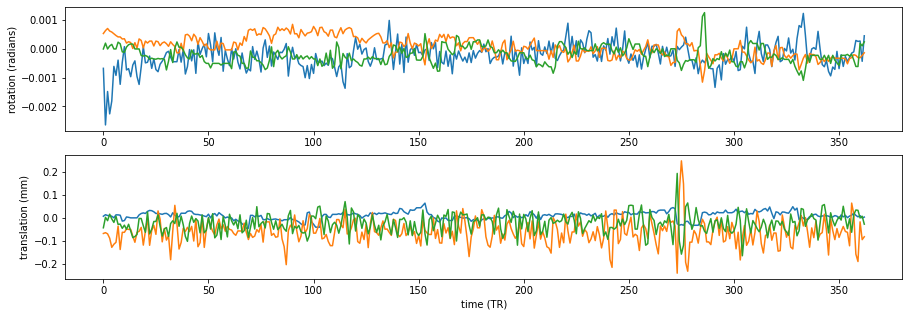

In [87]:
# Plot the motion paramters
par = np.loadtxt('/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_07_task_number_1/mcflirt/asub-07_ses-test_session1_bold_mcf.nii.gz.par')
fig, axes = plt.subplots(2, 1, figsize=(15, 5))
axes[0].set_ylabel('rotation (radians)')
axes[0].plot(par[0:, :3])
axes[1].plot(par[0:, 3:])
axes[1].set_xlabel('time (TR)')
axes[1].set_ylabel('translation (mm)')

The motion parameters seems to look ok. What about the detection of artifacts?

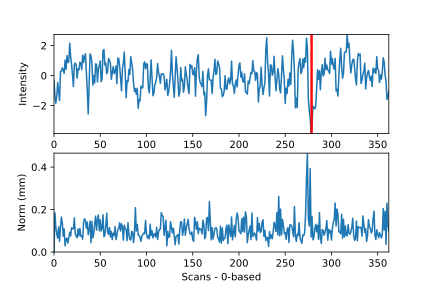

In [88]:
# Showing the artifact detection output
SVG(filename='/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_07_task_number_1/art/plot.asub-07_ses-test_session1_bold_mcf.svg')

In [89]:
outliers = np.loadtxt('/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_07_task_number_1/art/art.asub-07_ses-test_session1_bold_mcf_outliers.txt')
list(outliers.astype('int'))

[278, 279]

### Masks and Probability maps

Let's see what all the masks and probability maps look like. For this, we will use `nilearn`'s `plot_anat` function.

In the figure above, we see that at the very beginning there are extreme values, which hint to the fact that steady state wasn't reached yet. Therefore, we want to exclude the dummy scans from the original data. This can be achieved with FSL's `ExtractROI`.

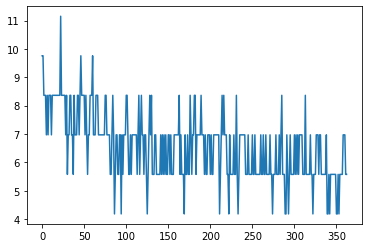

In [90]:
func_file = '/home/neuro/Data/Visual_search_task/BIDS_data/sub-07/ses-test/func/sub-07_ses-test_session1_bold.nii'
plt.plot(nb.load(func_file).get_fdata()[32, 32, 15, :])

In [94]:
output = '/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/_subject_id_07_task_number_1/'
anat = '/home/neuro/Data/Visual_search_task/BIDS_data/sub-07/ses-test/anat/sub-07_ses-test_anat_sT1W.nii'

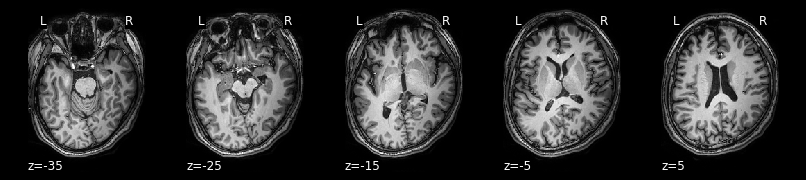

In [92]:
plot_anat(anat, cmap='gray', display_mode='z', cut_coords=range(-35, 15, 10), dim=-1)

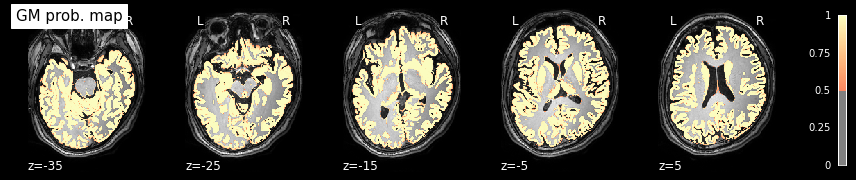

In [95]:
plot_stat_map(output + 'segment/c1sub-07_ses-test_anat_sT1W.nii', title='GM prob. map',  cmap=plt.cm.magma,
    threshold=0.5, bg_img=anat, display_mode='z', cut_coords=range(-35, 15, 10), dim=-1)

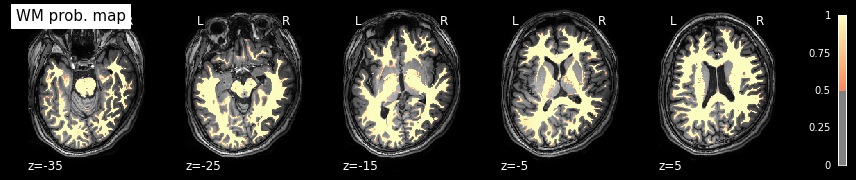

In [96]:
plot_stat_map(
    output + 'segment/c2sub-07_ses-test_anat_sT1W.nii', title='WM prob. map', cmap=plt.cm.magma,
    threshold=0.5, bg_img=anat, display_mode='z', cut_coords=range(-35, 15, 10), dim=-1);

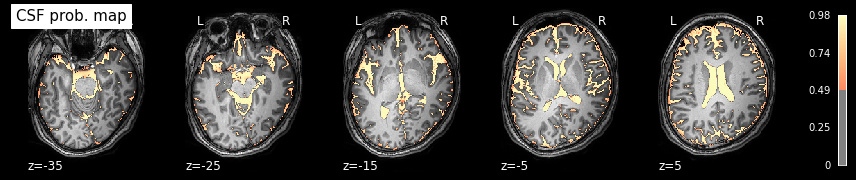

In [97]:
plot_stat_map(
    output + 'segment/c3sub-07_ses-test_anat_sT1W.nii', title='CSF prob. map', cmap=plt.cm.magma,
    threshold=0.5, bg_img=anat, display_mode='z', cut_coords=range(-35, 15, 10), dim=-1);

And how does the gray matter mask look like that we used on the functional images?

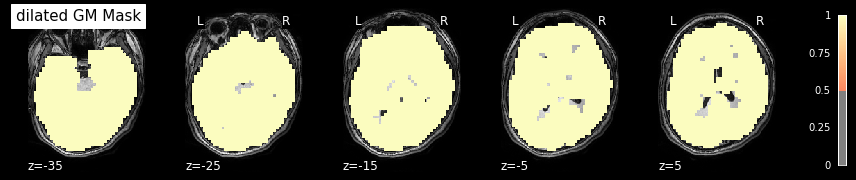

In [98]:
plot_stat_map(
    output + 'mask_GM/c1sub-07_ses-test_anat_sT1W_flirt_thresh.nii', title='dilated GM Mask', cmap=plt.cm.magma,
    threshold=0.5, bg_img=anat, display_mode='z', cut_coords=range(-35, 15, 10), dim=-1);

### Functional Image transformations

Let's also investigate the transformation that we applied to the functional images.

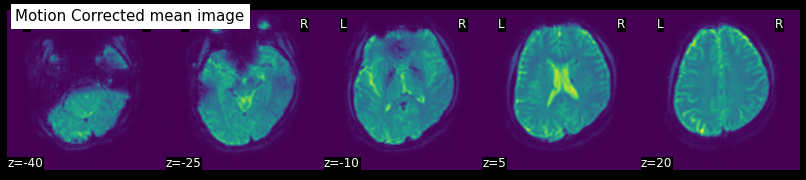

In [99]:
plot_epi(output + 'mcflirt/asub-07_ses-test_session1_bold_mcf.nii.gz_mean_reg.nii.gz',
         title='Motion Corrected mean image', display_mode='z', cut_coords=range(-40, 21, 15),
         cmap=plt.cm.viridis)

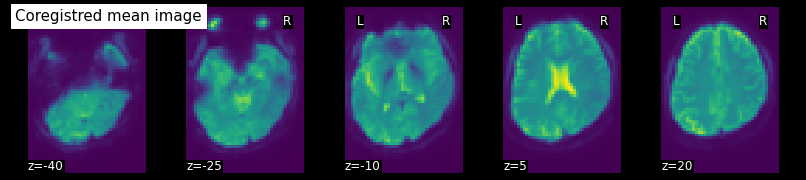

In [100]:
mean = nli.mean_img(output + 'applywarp/asub-07_ses-test_session1_bold_mcf_flirt.nii')
plot_epi(mean, title='Coregistred mean image', display_mode='z', cut_coords=range(-40, 21, 15),
         cmap=plt.cm.viridis)

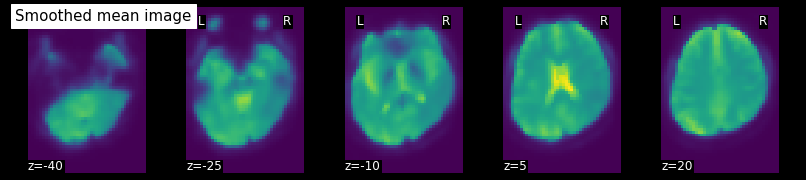

In [101]:
mean = nli.mean_img('/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/susan/_subject_id_07_task_number_1/smooth/mapflow/_smooth0/'
                    'asub-07_ses-test_session1_bold_mcf_flirt_smooth.nii.gz')
plot_epi(mean, title='Smoothed mean image', display_mode='z', cut_coords=range(-40, 21, 15),
         cmap=plt.cm.viridis);

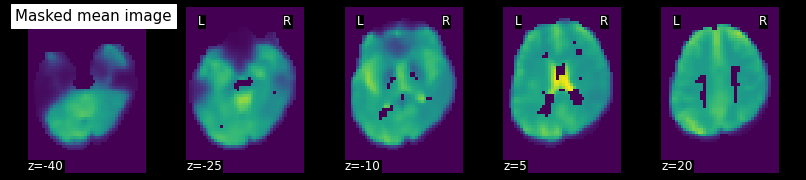

In [102]:
mean = nli.mean_img(output + 'mask_func/mapflow/_mask_func0/'
                    'asub-07_ses-test_session1_bold_mcf_flirt_smooth_masked.nii')
plot_epi(mean, title='Masked mean image', display_mode='z', cut_coords=range(-40, 21, 15),
         cmap=plt.cm.viridis)

That's all nice and beautiful, but what did smoothing and detrending actually do to the data?

/tmp/ipykernel_31933/2165104512.py:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  plt.plot(mc.get_data()[x, y, z, :])
/tmp/ipykernel_31933/2165104512.py:11: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  plt.plot(smooth.get_data()[x, y, z, :])
/tmp/ipykernel_31933/2165104512.py:12: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dat

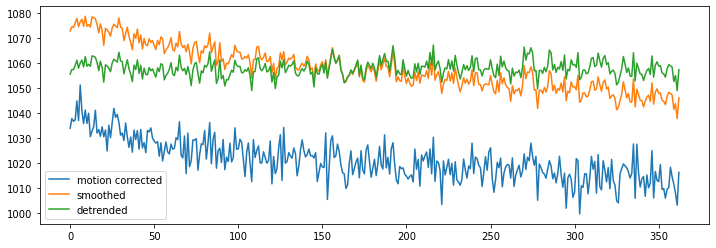

In [105]:
# Load the relevant datasets
mc = nb.load(output + 'applywarp/asub-07_ses-test_session1_bold_mcf_flirt.nii')
smooth = nb.load('/home/neuro/Result/Visual_search_task/preproc_working_dir/preproc/susan/_subject_id_07_task_number_1/smooth/mapflow/_smooth0/'
                    'asub-07_ses-test_session1_bold_mcf_flirt_smooth.nii.gz')
detrended_data = nb.load(output + 'detrend/detrend.nii.gz')

# Plot a representative voxel
x, y, z = 32, 34, 43
fig = plt.figure(figsize=(12, 4))
plt.plot(mc.get_data()[x, y, z, :])
plt.plot(smooth.get_data()[x, y, z, :])
plt.plot(detrended_data.get_data()[x, y, z, :])
plt.legend(['motion corrected', 'smoothed', 'detrended']);